# PREDICTION OF FUTURE CLOUD RESOURCES 

## MODULE 1 : FEATURE ENGINEERING, DECOMPOSITION AND CLUSTERING

### Importing  the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
from pandas import read_csv, datetime
from pandas.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.linear_model import LassoCV, RidgeCV
from itertools import product                    
from tqdm import tqdm_notebook

%matplotlib inline

import warnings                                
warnings.filterwarnings('ignore')

<ipython-input-1-ef81698f0dd8>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime


### Loading the dataset

In [2]:
path = r'rnd/2013-7/'                                         #month 1  500 csv files               
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)

concatenated_df   = pd.concat(df_from_each_file)

In [3]:

path =r'rnd/2013-8/'                                         #month 2   500 csv files 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df8   = pd.concat(df_from_each_file)

In [4]:
path = r'rnd/2013-9/'                                        #month 3   500 csv files 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f, sep = ';\t').assign(VM=os.path.basename(f).split('.')[0]) for f in all_files)
concatenated_df9   = pd.concat(df_from_each_file)

### Concatenating all the csv files 

In [5]:
newdat = concatenated_df.append(concatenated_df8)
newerdat = newdat.append(concatenated_df9)
concatenated_df = newerdat

In [6]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12496728 entries, 0 to 8302
Data columns (total 12 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Timestamp [ms]                         int64  
 1   CPU cores                              int64  
 2   CPU capacity provisioned [MHZ]         float64
 3   CPU usage [MHZ]                        float64
 4   CPU usage [%]                          float64
 5   Memory capacity provisioned [KB]       float64
 6   Memory usage [KB]                      float64
 7   Disk read throughput [KB/s]            float64
 8   Disk write throughput [KB/s]           float64
 9   Network received throughput [KB/s]     float64
 10  Network transmitted throughput [KB/s]  float64
 11  VM                                     object 
dtypes: float64(9), int64(2), object(1)
memory usage: 1.2+ GB


In [7]:
concatenated_df.head(10)

Timestamp [ms]  CPU cores  CPU capacity provisioned [MHZ]  CPU usage [MHZ]  \
0      1372629804          2                       5851.9989        87.779984   
1      1372630104          2                       5851.9989        29.259995   
2      1372630404          2                       5851.9989        27.309328   
3      1372630704          2                       5851.9989        23.407996   
4      1372631004          2                       5851.9989        19.506663   
5      1372631304          2                       5851.9989        29.259995   
6      1372631604          2                       5851.9989        29.259995   
7      1372631904          2                       5851.9989        29.259995   
8      1372632204          2                       5851.9989        29.259995   
9      1372632504          2                       5851.9989        19.506663   

   CPU usage [%]  Memory capacity provisioned [KB]  Memory usage [KB]  \
0       1.500000                         8218624.0       1.034593e+06   
1       0.500000                         8218624.0       4.585755e+05   
2       0.466667                         8218624.0       1.845480e+05   
3       0.400000                         8218624.0       7.829227e+04   
4       0.333333                         8218624.0       1.677720e+05   
5       0.500000                         8218624.0       3.914613e+04   
6       0.500000                         8218624.0       1.733632e+05   
7       0.500000                         8218624.0       9.506880e+04   
8       0.500000                         8218624.0       1.454019e+05   
9       0.333333                         8218624.0       1.118480e+04   

   Disk read throughput [KB/s]  Disk write throughput [KB/s]  \
0                   160.866667                     21.733333   
1                     0.000000                      2.333333   
2                    32.066667                      4.200000   
3                     0.000000                      0.866667   
4                     0.000000                      0.200000   
5                     0.000000                      0.266667   
6                     0.000000                      0.400000   
7                     0.000000                      0.200000   
8                     0.000000                      0.200000   
9                     0.000000                      1.000000   

   Network received throughput [KB/s]  Network transmitted throughput [KB/s]  \
0                            0.266667                               1.466667   
1                            0.200000                               1.000000   
2                            0.133333                               1.066667   
3                            0.066667                               1.000000   
4                            0.133333                               1.000000   
5                            0.200000                               1.000000   
6                            0.200000                               1.000000   
7                            0.533333                               1.000000   
8                            0.333333                               1.000000   
9                            0.400000                               1.133333   

  VM  
0  1  
1  1  
2  1  
3  1  
4  1  
5  1  
6  1  
7  1  
8  1  
9  1

In [8]:
concatenated_df.isnull().value_counts()

Timestamp [ms]  CPU cores  CPU capacity provisioned [MHZ]  CPU usage [MHZ]  CPU usage [%]  Memory capacity provisioned [KB]  Memory usage [KB]  Disk read throughput [KB/s]  Disk write throughput [KB/s]  Network received throughput [KB/s]  Network transmitted throughput [KB/s]  VM   
False           False      False                           False            False          False                             False              False                        False                         False                               False                                  False    12496728
dtype: int64

In [9]:
count_nan = len(concatenated_df) -concatenated_df.count()
print(count_nan)

Timestamp [ms]                           0
CPU cores                                0
CPU capacity provisioned [MHZ]           0
CPU usage [MHZ]                          0
CPU usage [%]                            0
Memory capacity provisioned [KB]         0
Memory usage [KB]                        0
Disk read throughput [KB/s]              0
Disk write throughput [KB/s]             0
Network received throughput [KB/s]       0
Network transmitted throughput [KB/s]    0
VM                                       0
dtype: int64


In [10]:
concatenated_df = concatenated_df.bfill()

In [11]:
count_nan = len(concatenated_df) -concatenated_df.count()
print(count_nan)

Timestamp [ms]                           0
CPU cores                                0
CPU capacity provisioned [MHZ]           0
CPU usage [MHZ]                          0
CPU usage [%]                            0
Memory capacity provisioned [KB]         0
Memory usage [KB]                        0
Disk read throughput [KB/s]              0
Disk write throughput [KB/s]             0
Network received throughput [KB/s]       0
Network transmitted throughput [KB/s]    0
VM                                       0
dtype: int64


In [12]:
concatenated_df.head(10)

Timestamp [ms]  CPU cores  CPU capacity provisioned [MHZ]  CPU usage [MHZ]  \
0      1372629804          2                       5851.9989        87.779984   
1      1372630104          2                       5851.9989        29.259995   
2      1372630404          2                       5851.9989        27.309328   
3      1372630704          2                       5851.9989        23.407996   
4      1372631004          2                       5851.9989        19.506663   
5      1372631304          2                       5851.9989        29.259995   
6      1372631604          2                       5851.9989        29.259995   
7      1372631904          2                       5851.9989        29.259995   
8      1372632204          2                       5851.9989        29.259995   
9      1372632504          2                       5851.9989        19.506663   

   CPU usage [%]  Memory capacity provisioned [KB]  Memory usage [KB]  \
0       1.500000                         8218624.0       1.034593e+06   
1       0.500000                         8218624.0       4.585755e+05   
2       0.466667                         8218624.0       1.845480e+05   
3       0.400000                         8218624.0       7.829227e+04   
4       0.333333                         8218624.0       1.677720e+05   
5       0.500000                         8218624.0       3.914613e+04   
6       0.500000                         8218624.0       1.733632e+05   
7       0.500000                         8218624.0       9.506880e+04   
8       0.500000                         8218624.0       1.454019e+05   
9       0.333333                         8218624.0       1.118480e+04   

   Disk read throughput [KB/s]  Disk write throughput [KB/s]  \
0                   160.866667                     21.733333   
1                     0.000000                      2.333333   
2                    32.066667                      4.200000   
3                     0.000000                      0.866667   
4                     0.000000                      0.200000   
5                     0.000000                      0.266667   
6                     0.000000                      0.400000   
7                     0.000000                      0.200000   
8                     0.000000                      0.200000   
9                     0.000000                      1.000000   

   Network received throughput [KB/s]  Network transmitted throughput [KB/s]  \
0                            0.266667                               1.466667   
1                            0.200000                               1.000000   
2                            0.133333                               1.066667   
3                            0.066667                               1.000000   
4                            0.133333                               1.000000   
5                            0.200000                               1.000000   
6                            0.200000                               1.000000   
7                            0.533333                               1.000000   
8                            0.333333                               1.000000   
9                            0.400000                               1.133333   

  VM  
0  1  
1  1  
2  1  
3  1  
4  1  
5  1  
6  1  
7  1  
8  1  
9  1

### Converting dataframe to time series

In [13]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.apply(pd.to_numeric, errors='ignore')

concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day
concatenated_df.set_index('Timestamp',inplace=True)

concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df["Network received throughput [KB/s]"] - concatenated_df["received_prev"]
concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]'] - concatenated_df["transmitted_prev"]

In [14]:
concatenated_df = concatenated_df.fillna(method='ffill')

In [15]:
concatenated_df.head()

Timestamp [ms]  CPU cores  \
Timestamp                                        
2013-06-30 22:03:24      1372629804          2   
2013-06-30 22:08:24      1372630104          2   
2013-06-30 22:13:24      1372630404          2   
2013-06-30 22:18:24      1372630704          2   
2013-06-30 22:23:24      1372631004          2   

                     CPU capacity provisioned [MHZ]  CPU usage [MHZ]  \
Timestamp                                                              
2013-06-30 22:03:24                       5851.9989        87.779984   
2013-06-30 22:08:24                       5851.9989        29.259995   
2013-06-30 22:13:24                       5851.9989        27.309328   
2013-06-30 22:18:24                       5851.9989        23.407996   
2013-06-30 22:23:24                       5851.9989        19.506663   

                     CPU usage [%]  Memory capacity provisioned [KB]  \
Timestamp                                                              
2013-06-30 22:03:24       1.500000                         8218624.0   
2013-06-30 22:08:24       0.500000                         8218624.0   
2013-06-30 22:13:24       0.466667                         8218624.0   
2013-06-30 22:18:24       0.400000                         8218624.0   
2013-06-30 22:23:24       0.333333                         8218624.0   

                     Memory usage [KB]  Disk read throughput [KB/s]  \
Timestamp                                                             
2013-06-30 22:03:24       1.034593e+06                   160.866667   
2013-06-30 22:08:24       4.585755e+05                     0.000000   
2013-06-30 22:13:24       1.845480e+05                    32.066667   
2013-06-30 22:18:24       7.829227e+04                     0.000000   
2013-06-30 22:23:24       1.677720e+05                     0.000000   

                     Disk write throughput [KB/s]  \
Timestamp                                           
2013-06-30 22:03:24                     21.733333   
2013-06-30 22:08:24                      2.333333   
2013-06-30 22:13:24                      4.200000   
2013-06-30 22:18:24                      0.866667   
2013-06-30 22:23:24                      0.200000   

                     Network received throughput [KB/s]  ...  weekday weekend  \
Timestamp                                                ...                    
2013-06-30 22:03:24                            0.266667  ...        6     1.0   
2013-06-30 22:08:24                            0.200000  ...        6     1.0   
2013-06-30 22:13:24                            0.133333  ...        6     1.0   
2013-06-30 22:18:24                            0.066667  ...        6     1.0   
2013-06-30 22:23:24                            0.133333  ...        6     1.0   

                     month  day  CPU usage prev  CPU_diff  received_prev  \
Timestamp                                                                  
2013-06-30 22:03:24      6   30             NaN       NaN            NaN   
2013-06-30 22:08:24      6   30        1.500000 -1.000000       0.266667   
2013-06-30 22:13:24      6   30        0.500000 -0.033333       0.200000   
2013-06-30 22:18:24      6   30        0.466667 -0.066667       0.133333   
2013-06-30 22:23:24      6   30        0.400000 -0.066667       0.066667   

                     received_diff  transmitted_prev  transmitted_diff  
Timestamp                                                               
2013-06-30 22:03:24            NaN               NaN               NaN  
2013-06-30 22:08:24      -0.066667          1.466667         -0.466667  
2013-06-30 22:13:24      -0.066667          1.000000          0.066667  
2013-06-30 22:18:24      -0.066667          1.066667         -0.066667  
2013-06-30 22:23:24       0.066667          1.000000          0.000000  

[5 rows x 22 columns]

In [16]:
hourlydat = concatenated_df.resample('H').sum()

In [17]:
hourlydat.to_csv('hourlydat.csv', sep = ',')

In [18]:
#data = pd.read_csv("hourlydat.csv")
data=hourlydat[['Disk read throughput [KB/s]' ,'CPU usage [MHZ]']]
data.head()

Disk read throughput [KB/s]  CPU usage [MHZ]
Timestamp                                                        
2013-06-30 22:00:00                 7.029850e+05     1.677022e+06
2013-06-30 23:00:00                 9.123973e+05     1.817519e+06
2013-07-01 00:00:00                 9.670129e+05     1.719936e+06
2013-07-01 01:00:00                 1.628856e+06     1.649799e+06
2013-07-01 02:00:00                 1.413094e+06     1.731963e+06

### Decomposing CPU usage

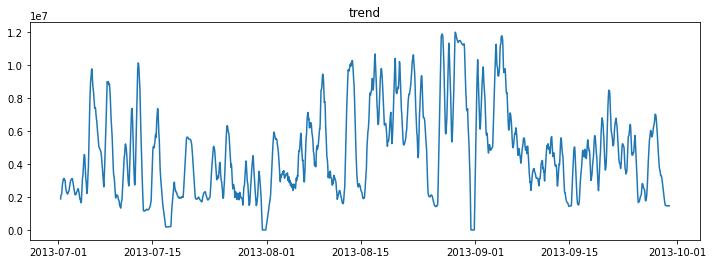

In [19]:
df=hourlydat['CPU usage [MHZ]']
t = df.rolling(window=12).mean()
plt.figure(figsize=(12,4));
plt.plot(t);
plt.title('trend');

In [20]:
seasonal_component = df /decomp.trend
plt.figure(figsize=(12,4))
plt.plot(seasonal_component);

plt.title('S=Y/T');

NameError: name 'decomp' is not defined

In [ ]:

residual_component= df/(decomp.trend*decomp.seasonal)
plt.figure(figsize=(12,4))
plt.plot(residual_component)
plt.title('R = Y / (S*T)')
plt.figure(figsize=(10,5))
autocorrelation_plot(residual_component);
plt.show();

In [ ]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose




decomp = seasonal_decompose(hourlydat['CPU usage [MHZ]'], model="additive")

plt.figure(figsize=(15,5))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(11.7, 8.27)

ax1.plot(hourlydat['CPU usage [MHZ]'])
ax2.plot(decomp.trend)
ax3.plot(decomp.seasonal)
ax4.plot(decomp.resid)
sns.despine()

### Clustering CPU usage

In [ ]:
!pip install minisom
!pip install tslearn

In [ ]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [ ]:
mySeries = []
namesofMySeries = []
df = pd.read_csv("hourlydat.csv")
df =  df.loc[:,["Timestamp","CPU usage [MHZ]"]]
        # While we are at it I just filtered the columns that we will be working on
df.set_index("Timestamp",inplace=True)
        # ,set the date columns as index
df.sort_index(inplace=True)
        # and lastly, ordered the data according to our date index
mySeries.append(df)
#namesofMySeries.append([:-4])

In [ ]:
print(mySeries)


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=3)

In [ ]:
kmeans.fit(data)

In [ ]:
kmeans.cluster_centers_

In [ ]:
kmeans.labels_

In [ ]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict_data = dict(zip(unique, counts))
dict_data

In [ ]:
data["cluster"] = kmeans.labels_

In [ ]:
sns.lmplot(x='Disk read throughput [KB/s]',y='CPU usage [MHZ]', data=data, hue='cluster', palette='coolwarm', size=6, aspect=1, fit_reg=False)

In [ ]:
kmeans.inertia_

In [ ]:
kmeans.score

In [ ]:
data.head(10)


## MODULE 2 : UNDERSTANDING CORRELATIONS AND DATA VISUALIZATION

### Autocorrelations of hourly transmitted, received, and CPU usage

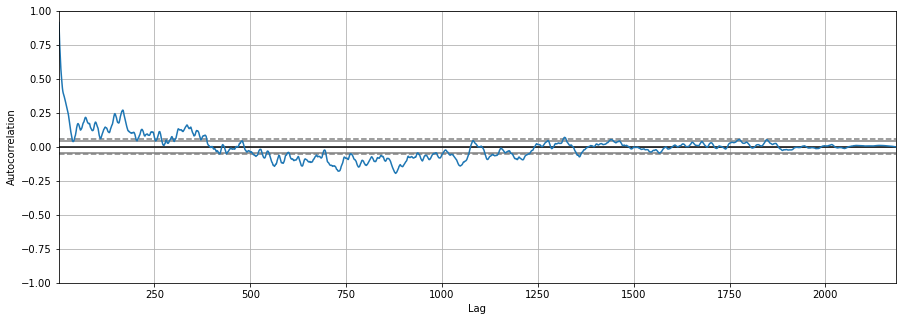

In [19]:
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(hourlydat['CPU usage [MHZ]']);

In [20]:
overprovision = pd.DataFrame(hourlydat['CPU usage [MHZ]'])
overprovision['CPU capacity provisioned'] = pd.DataFrame(hourlydat['CPU capacity provisioned [MHZ]'])


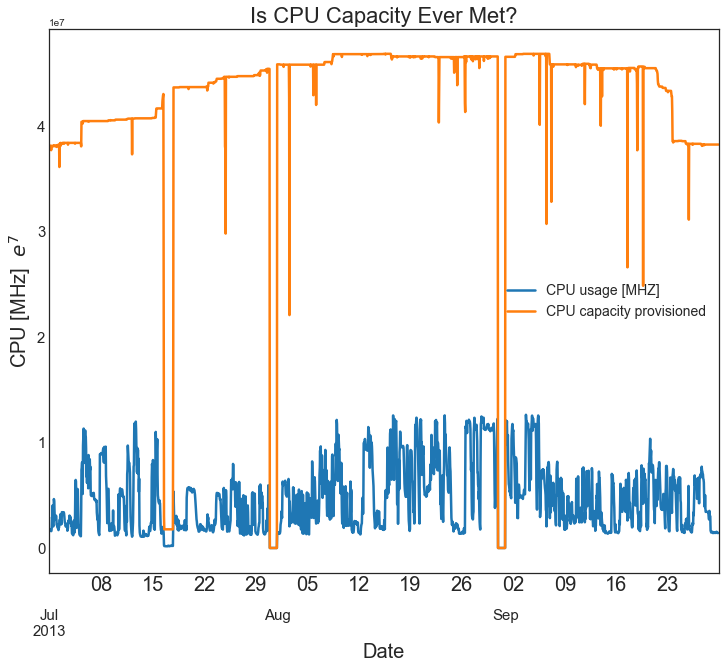

In [21]:
plt.style.use('seaborn-white')
overprovision.plot(figsize = (12,10),linewidth=2.5, fontsize=20)
plt.title('Is CPU Capacity Ever Met?',fontsize=22)
plt.ylabel((r'CPU [MHz]  $e^{7}$'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.tick_params(labelsize=15)
plt.xticks( fontsize = 15)
plt.legend(loc="best", fontsize =14)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (1,6))
plt.savefig('CPU_cap_under.png')
plt.show()

### One month CPU provision

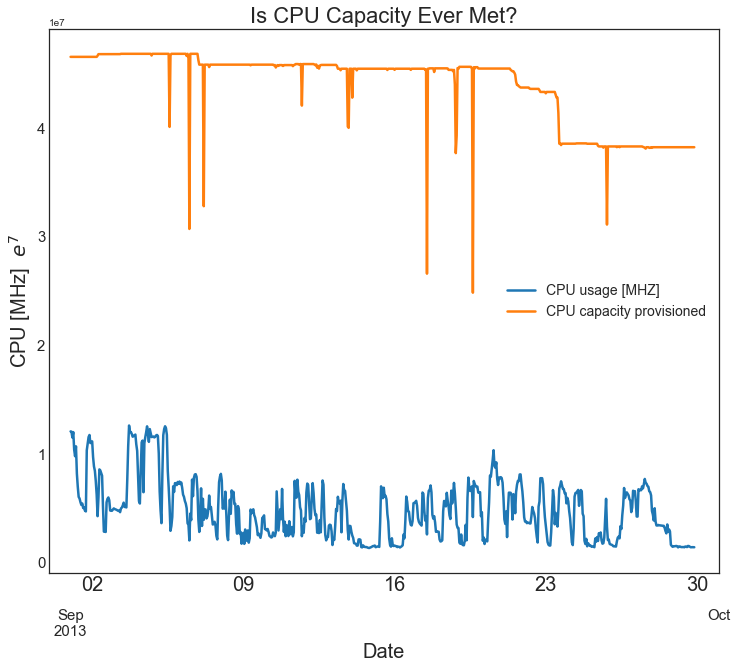

In [22]:
import datetime
plt.style.use('seaborn-white')
overprovision[(overprovision.index > '2013-08-31 23:59:00') & (overprovision.index < '2013-10-01 0:00:00')].plot(figsize = (12,10),linewidth=2.5,fontsize=20)
plt.title('Is CPU Capacity Ever Met?',fontsize=22)
plt.ylabel((r'CPU [MHz]  $e^{7}$'), fontsize=20);
plt.xlabel('Date', fontsize=20);
plt.tick_params(labelsize=15)
plt.xlim([datetime.date(2013, 8, 31), datetime.date(2013, 10, 1)])
plt.xticks( fontsize = 15)
plt.legend(loc="best", fontsize =14)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (1,6))
plt.savefig('CPU_cap_under_1mo.png')
plt.show()

In [23]:
print("avg CPU Percent Usage is only: " + str(round(concatenated_df['CPU usage [%]'].mean(),2)))
print("min CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].min(),2)))
print("maximum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].max(),2)))

avg CPU Percent Usage is only: 6.01
min CPU Percent Usage is: 0.0
maximum CPU Percent Usage is: 182.13


### Aggregated graphs

In [24]:
cpu = concatenated_df[['CPU usage [MHZ]']]
receive = concatenated_df[['Network received throughput [KB/s]']]
transmit = concatenated_df[['Network transmitted throughput [KB/s]']]
provisioned = concatenated_df[['CPU capacity provisioned [MHZ]']]

hourlycpu = cpu.resample('H').sum()
hourlytransmit = transmit.resample('H').sum()
hourlyreceive = receive.resample('H').sum()
hourlyprovisioned = provisioned.resample('H').sum()

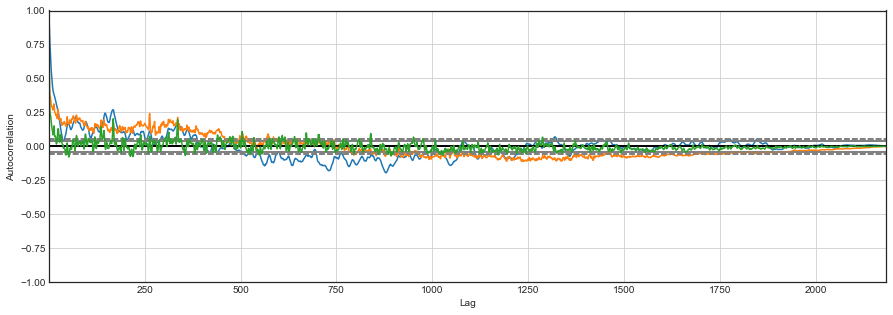

In [25]:
plt.figure(figsize=(15,5))

pd.plotting.autocorrelation_plot(hourlycpu);
pd.plotting.autocorrelation_plot(hourlyreceive);
pd.plotting.autocorrelation_plot(hourlytransmit);

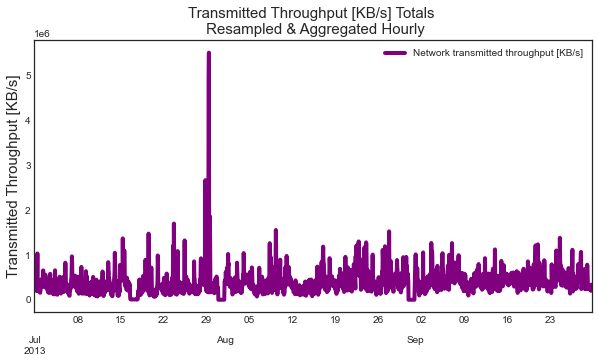

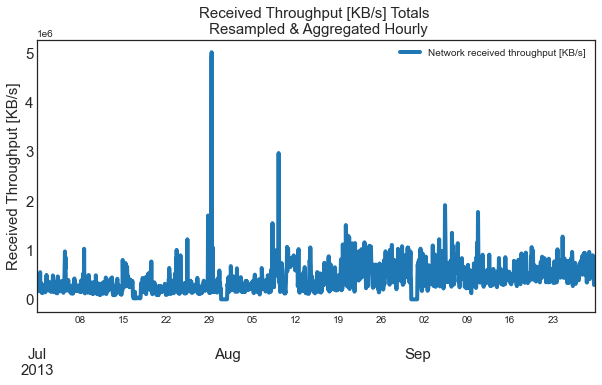

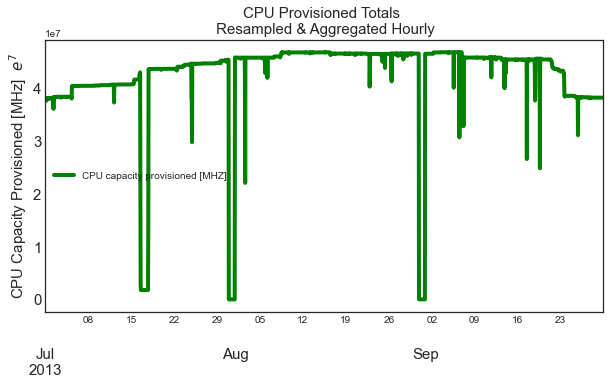

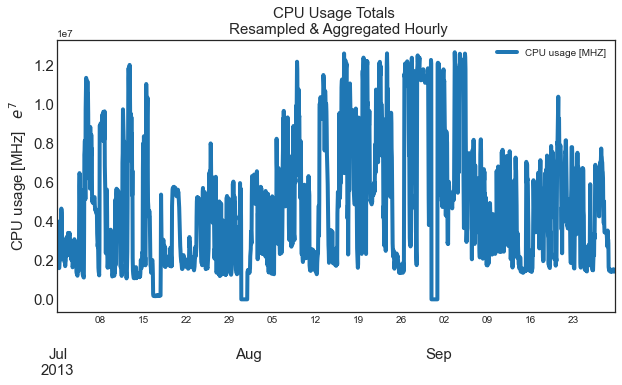

In [26]:
hourlytransmit.plot(color = "purple",linewidth = 4,  figsize=(10, 5))
plt.title('Transmitted Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Transmitted Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);

hourlyreceive.plot( linewidth = 4, figsize=(10, 5))
plt.title('Received Throughput [KB/s] Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('Received Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlyprovisioned.plot(color = "g", linewidth = 4, figsize=(10, 5))
plt.title('CPU Provisioned Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU Capacity Provisioned [MHz]  $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlycpu.plot(linewidth = 4, figsize=(10, 5))
plt.title('CPU Usage Totals \n Resampled & Aggregated Hourly',fontsize=15);
plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

### Max value graphs

In [27]:
cpu = concatenated_df[['CPU usage [MHZ]']]
receive = concatenated_df[['Network received throughput [KB/s]']]
transmit = concatenated_df[['Network transmitted throughput [KB/s]']]
provisioned = concatenated_df[['CPU capacity provisioned [MHZ]']]

hourlycpu = cpu.resample('H').max()
hourlytransmit = transmit.resample('H').max()
hourlyreceive = receive.resample('H').max()
hourlyprovisioned = provisioned.resample('H').max()


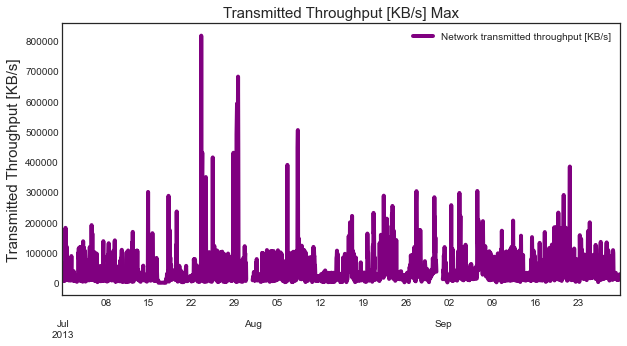

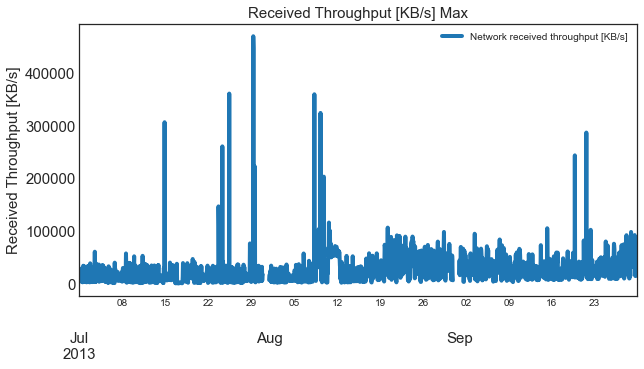

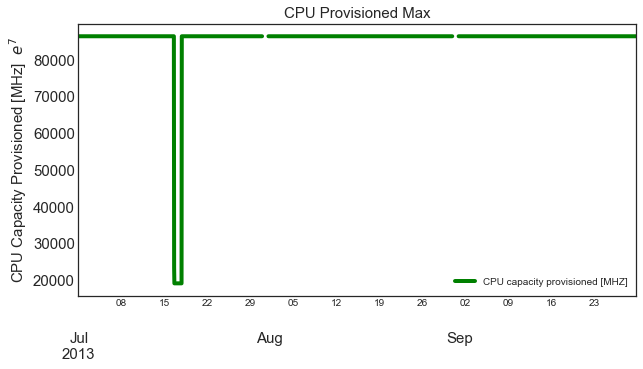

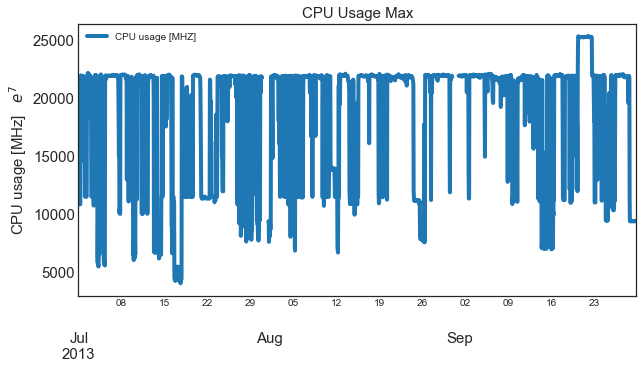

In [28]:
hourlytransmit.plot(color = "purple",linewidth = 4,  figsize=(10, 5))
plt.title('Transmitted Throughput [KB/s] Max',fontsize=15);
plt.ylabel('Transmitted Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);

hourlyreceive.plot( linewidth = 4, figsize=(10, 5))
plt.title('Received Throughput [KB/s] Max',fontsize=15);
plt.ylabel('Received Throughput [KB/s]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlyprovisioned.plot(color = "g", linewidth = 4, figsize=(10, 5))
plt.title('CPU Provisioned Max',fontsize=15);
plt.ylabel('CPU Capacity Provisioned [MHz]  $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

hourlycpu.plot(linewidth = 4, figsize=(10, 5))
plt.title('CPU Usage Max',fontsize=15);
plt.ylabel('CPU usage [MHz]   $e^{7}$', fontsize=15);
plt.xlabel('', fontsize=15);
plt.yticks(fontsize=15);
plt.xticks(fontsize=15);

### Rolling Mean Visualization

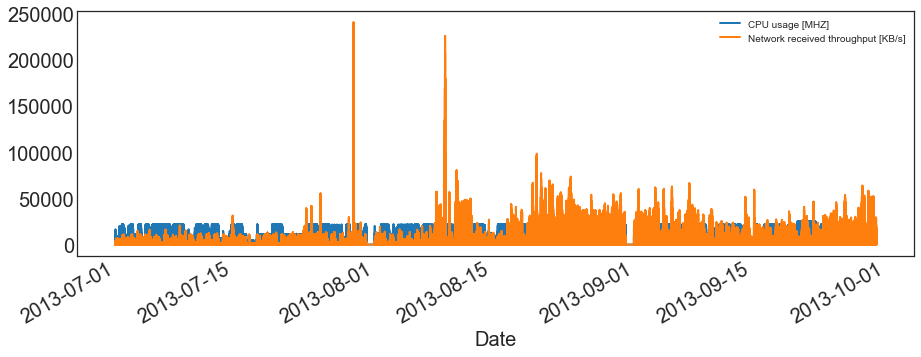

In [29]:
df_rm = pd.concat([cpu.rolling(12).mean(), receive.rolling(12).mean()], axis=1)
df_rm.plot(figsize=(15,5), linewidth=2, fontsize=20)
plt.xlabel('Date', fontsize=20);

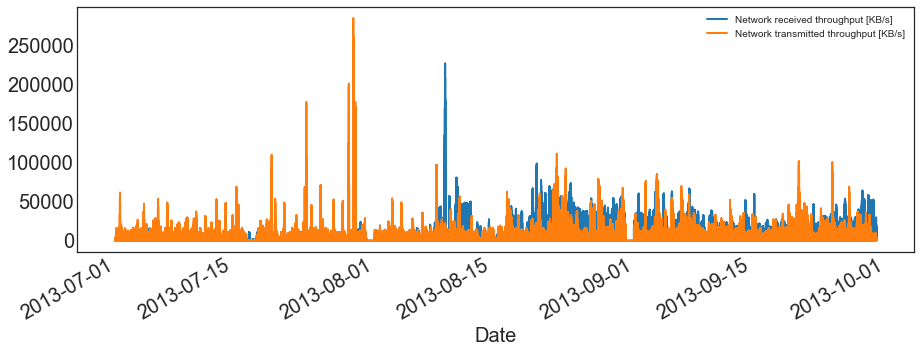

In [30]:
df_rm = pd.concat([receive.rolling(12).mean(), transmit.rolling(12).mean()], axis=1)
df_rm.plot(figsize=(15,5), linewidth=2, fontsize=20)
plt.xlabel('Date', fontsize=20);

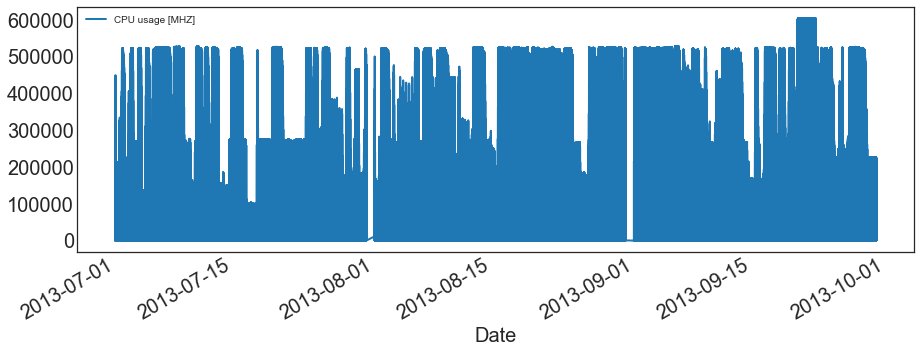

In [31]:
df_rm = pd.concat([cpu.rolling(24).sum()], axis=1)
df_rm.plot(figsize=(15,5), linewidth=2, fontsize=20)
plt.xlabel('Date', fontsize=20);


In [32]:
hourlydat = hourlydat[['CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]','Memory capacity provisioned [KB]','Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]','CPU usage prev', 'CPU_diff', 'received_prev', 'received_diff','transmitted_prev', 'transmitted_diff', 'weekday', 'weekend', 'month', 'day','CPU cores']]

hourlydatrest = hourlydat[hourlydat.columns[15:21]]


from scipy.stats import zscore

standardizeddf = hourlydat.iloc[1:]
standardizeddf = standardizeddf[standardizeddf.columns[0:15]].apply(zscore)

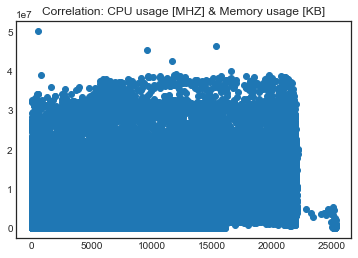

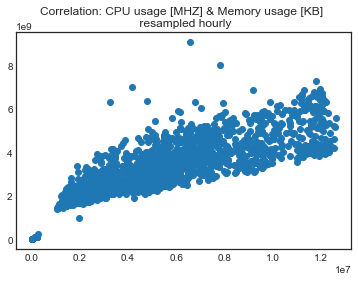

In [33]:
concatenated_df['CPU usage [MHZ]']
plt.scatter(concatenated_df['CPU usage [MHZ]'], concatenated_df['Memory usage [KB]'])
plt.title("Correlation: CPU usage [MHZ] & Memory usage [KB]")
plt.show()


plt.scatter(hourlydat['CPU usage [MHZ]'], hourlydat['Memory usage [KB]'])
plt.title("Correlation: CPU usage [MHZ] & Memory usage [KB] \n resampled hourly")
plt.show()

In [34]:

hourlydat = hourlydat[['CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]','Memory capacity provisioned [KB]','Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]','CPU usage prev', 'CPU_diff', 'received_prev', 'received_diff','transmitted_prev', 'transmitted_diff', 'weekday', 'weekend', 'month', 'day','CPU cores']]

In [35]:
from scipy.stats import zscore
#remove first row with NA's from previous shift, that way we can get z scores
standardizeddf = hourlydat.iloc[1:]
standardizeddf = standardizeddf[standardizeddf.columns[0:15]].apply(zscore)

In [36]:
standardizeddf.head()
standardizeddf.describe()

CPU capacity provisioned [MHZ]  CPU usage [MHZ]  CPU usage [%]  \
count                    2.183000e+03     2.183000e+03   2.183000e+03   
mean                     5.863890e-17     3.477648e-16   1.107680e-16   
std                      1.000229e+00     1.000229e+00   1.000229e+00   
min                     -4.926312e+00    -1.479422e+00  -2.086687e+00   
25%                     -2.113730e-01    -8.330708e-01  -7.743911e-01   
50%                      3.372241e-01    -1.957958e-01  -1.373724e-01   
75%                      4.619716e-01     5.787882e-01   6.322893e-01   
max                      4.966170e-01     2.494483e+00   2.567443e+00   

       Memory capacity provisioned [KB]  Memory usage [KB]  \
count                      2.183000e+03       2.183000e+03   
mean                       6.525040e-17       1.232790e-16   
std                        1.000229e+00       1.000229e+00   
min                       -4.898862e+00      -2.250355e+00   
25%                        1.188779e-01      -7.456365e-01   
50%                        3.247825e-01      -2.240944e-01   
75%                        3.707253e-01       6.739569e-01   
max                        5.099616e-01       4.729503e+00   

       Disk read throughput [KB/s]  Disk write throughput [KB/s]  \
count                 2.183000e+03                  2.183000e+03   
mean                 -1.497250e-16                  3.951641e-16   
std                   1.000229e+00                  1.000229e+00   
min                  -1.474665e+00                 -2.015655e+00   
25%                  -6.749043e-01                 -6.110454e-01   
50%                  -2.699903e-01                 -3.137259e-01   
75%                   4.192140e-01                  5.042843e-01   
max                   5.416161e+00                  7.292139e+00   

       Network received throughput [KB/s]  \
count                        2.183000e+03   
mean                         6.137758e-16   
std                          1.000229e+00   
min                         -1.425980e+00   
25%                         -6.724202e-01   
50%                         -1.768669e-01   
75%                          4.744757e-01   
max                          1.592255e+01   

       Network transmitted throughput [KB/s]  CPU usage prev      CPU_diff  \
count                           2.183000e+03    2.183000e+03  2.183000e+03   
mean                            7.893111e-17    1.947849e-16 -1.204612e-17   
std                             1.000229e+00    1.000229e+00  1.000229e+00   
min                            -1.380742e+00   -2.086690e+00 -6.920469e+00   
25%                            -5.606087e-01   -7.745441e-01 -3.633997e-01   
50%                            -1.533186e-01   -1.360214e-01 -2.290613e-02   
75%                             3.129108e-01    6.313547e-01  2.222117e-01   
max                             1.859779e+01    2.546173e+00  6.270234e+00   

       received_prev  received_diff  transmitted_prev  transmitted_diff  
count   2.183000e+03   2.183000e+03      2.183000e+03      2.183000e+03  
mean   -8.908739e-16  -6.287280e-18      5.304455e-17     -2.797172e-18  
std     1.000229e+00   1.000229e+00      1.000229e+00      1.000229e+00  
min    -1.413444e+00  -1.252132e+01     -1.360627e+00     -1.473853e+01  
25%    -6.675275e-01  -2.397130e-01     -5.414705e-01     -1.467964e-01  
50%    -1.765295e-01   3.092801e-05     -1.482086e-01      2.401020e-04  
75%     4.645976e-01   2.186667e-01      3.079334e-01      1.571210e-01  
max     1.728272e+01   1.031131e+01      2.006856e+01      1.411753e+01

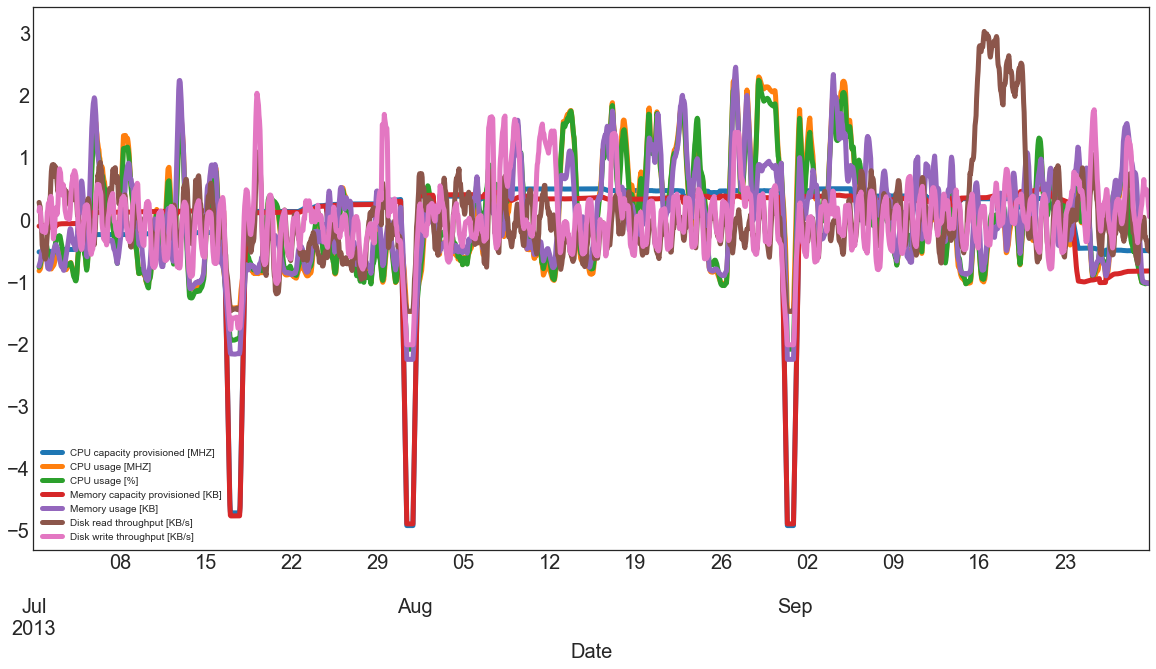

In [37]:
df_rm2 = standardizeddf.iloc[:,0:7].rolling(12).mean()
df_rm2.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

### Hourly Data Visualization

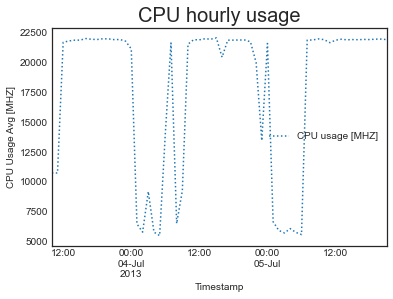

In [38]:
hourlycpu[60:120].plot(style=[':', '--', '-'])
plt.title('CPU hourly usage',fontsize=20);
plt.ylabel('CPU Usage Avg [MHZ]');


### Weekend, Weekday Visualization

In [39]:
hourlydat = concatenated_df.resample('H').sum()
hourlydat['Date_Time'] = hourlydat.index
hourlydat['weekday'] = hourlydat['Date_Time'].dt.dayofweek
hourlydat['weekend'] = ((hourlydat.weekday) // 5 == 1).astype(float)

In [40]:
hourlydat['month']=hourlydat['Date_Time'].dt.month 
hourlydat['day']=hourlydat['Date_Time'].dt.day
hourlydat.drop('Date_Time', axis=1, inplace=True)
hourlydat.drop('Timestamp [ms]', axis=1, inplace=True)


In [41]:
plotdays = hourlydat.groupby('weekday').agg({'CPU usage [MHZ]': ['mean']})
plotdays = pd.DataFrame(plotdays)

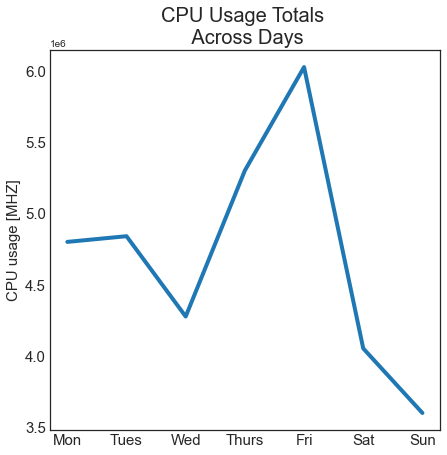

In [42]:
plotdays.plot(linewidth = 4, figsize=(7, 7),legend=None)
plt.title('CPU Usage Totals \n Across Days',fontsize=20);
plt.ylabel('CPU usage [MHZ]', fontsize=15);
plt.xlabel('', fontsize=15);
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=15);
plt.yticks(fontsize=15);

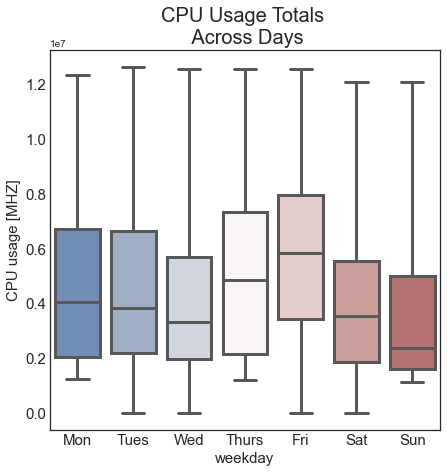

In [43]:
plt.figure(figsize=(7,7))
plt.title('CPU Usage Totals \n Across Days',fontsize=20);
plt.ylabel('CPU usage [MHZ]', fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('', fontsize=15);
sns.boxplot(y=hourlydat['CPU usage [MHZ]'],x = hourlydat.weekday,
            whis=np.inf, palette="vlag",linewidth=3)
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=15);


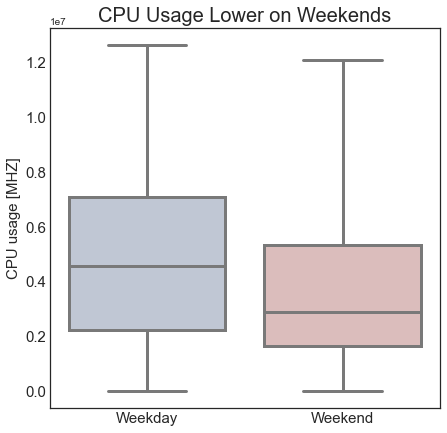

In [44]:
plt.figure(figsize=(7,7))
plt.title('CPU Usage Lower on Weekends',fontsize=20);
plt.ylabel('CPU usage [MHZ]', fontsize=15);
plt.yticks(fontsize=15);
sns.boxplot(y=hourlydat['CPU usage [MHZ]'],x = hourlydat.weekend,
            whis=np.inf, palette="vlag",linewidth=3)
plt.xticks(np.arange(2), ('Weekday', 'Weekend'), fontsize=15);
plt.xlabel('', fontsize=15);

### Correlation visualization

<AxesSubplot:>

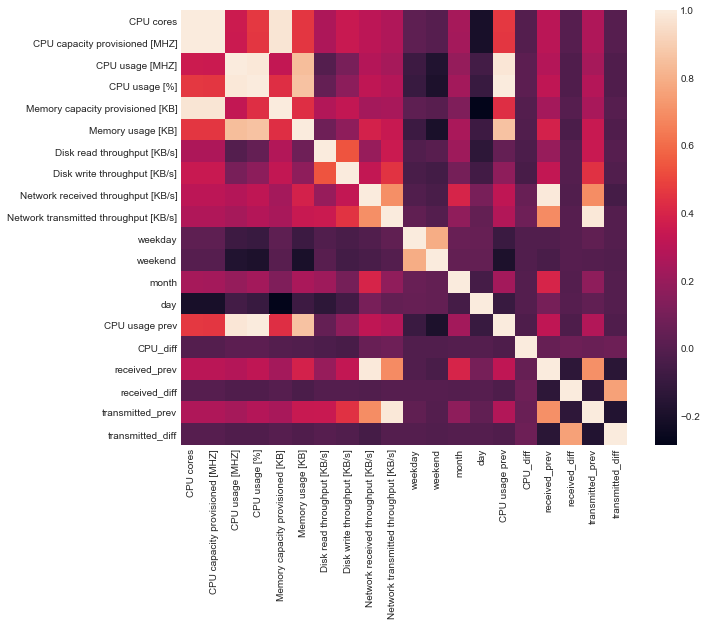

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(hourlydat.corr())

### Moving average - smoothening of data

In [46]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
def moving_average(series, n):
   
    return np.average(series[-n:])

In [48]:
from sklearn.metrics import classification_report

def classify(X_test,y_test):
    print(classification_report(X_test,y_test))

In [49]:
## FUNCTION TO PLOT MOVING AVG


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15,7))
    plt.title("Moving Average (window size = {})".format(window), fontsize = 20)
    plt.ylabel('Network transmitted throughput [KB/s]   $e^{7}$', fontsize=16);
    plt.xlabel('Time', fontsize=16);
    plt.yticks(fontsize=15);
    plt.xticks(fontsize=15);
    plt.plot(rolling_mean, "purple", label="Rolling Mean Trend",linewidth = 5)

    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper/Lower Bound", linewidth = 1)
        plt.plot(lower_bond, "r--", linewidth = 1)
        
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, label = "Anomalies")
        
    plt.plot(series[window:], label="Actual CPU Usage", linewidth = 1)
    plt.legend(loc="upper right", fontsize =13)
    plt.grid(True)

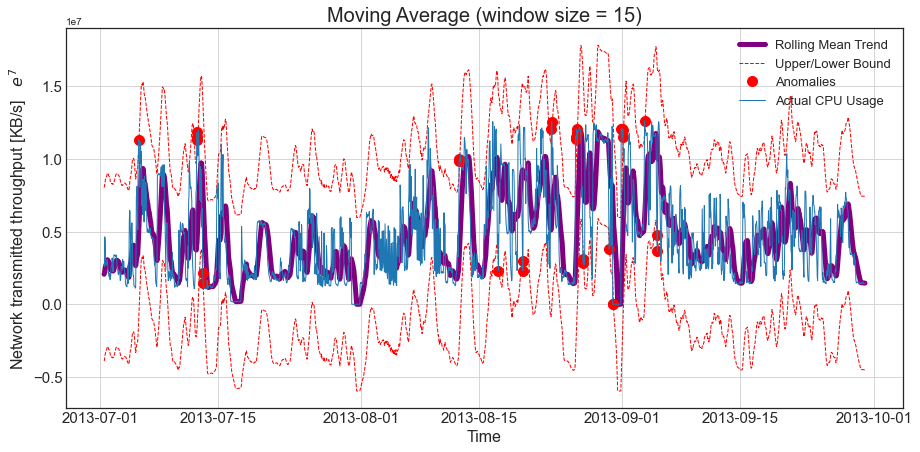

In [50]:
plotMovingAverage(hourlydat[['CPU usage [MHZ]']], 15, plot_intervals=True, plot_anomalies=True)

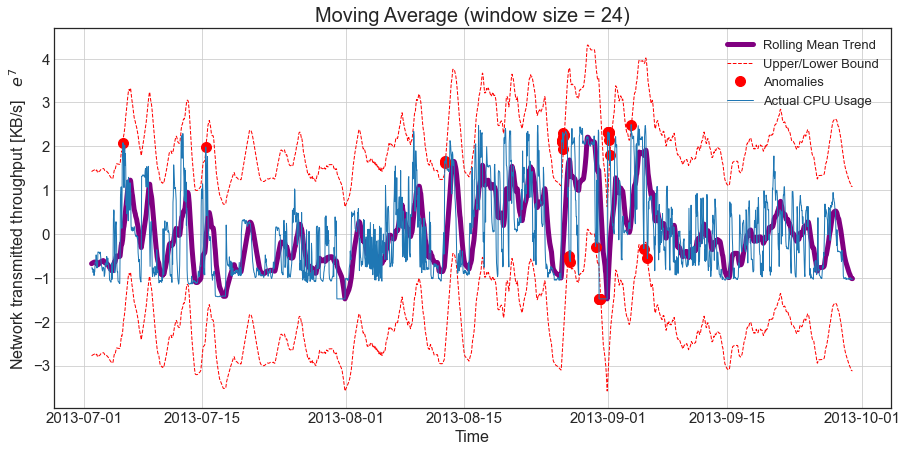

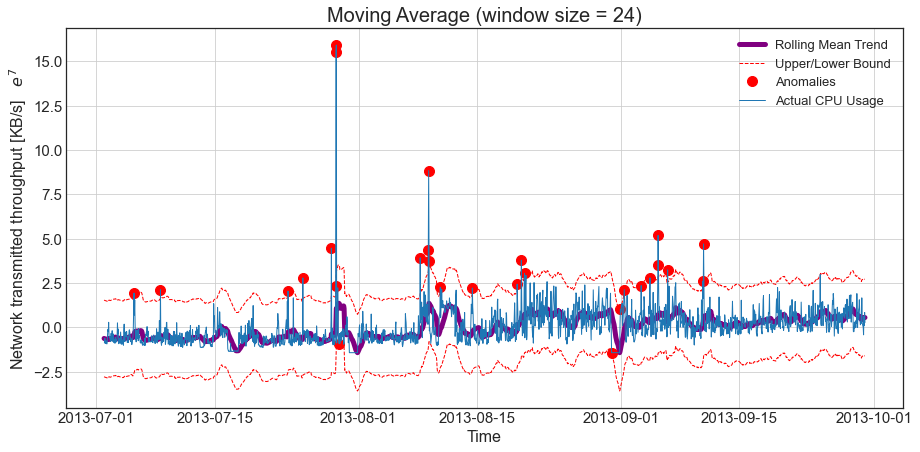

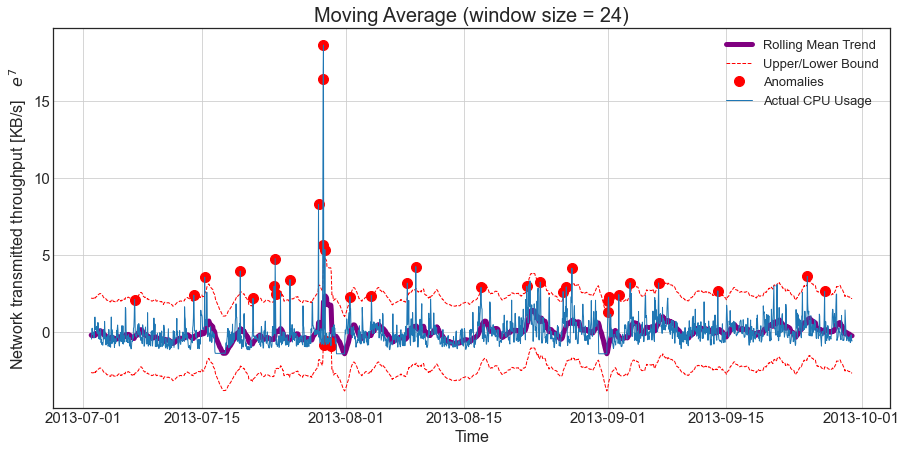

In [51]:
plotMovingAverage(standardizeddf[['CPU usage [MHZ]']], 24, plot_intervals=True, plot_anomalies=True)

plotMovingAverage(standardizeddf[['Network received throughput [KB/s]']], 24, plot_intervals=True, plot_anomalies=True)

plotMovingAverage(standardizeddf[['Network transmitted throughput [KB/s]']], 24, plot_intervals=True, plot_anomalies=True)

### ADF Test - Stationarity

In [52]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(hourlydat['CPU usage [MHZ]'])

# formats stats output
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                -6.633146e+00
p-value                        5.648578e-09
# of Lags Used                 1.200000e+01
Number of Observations Used    2.171000e+03
Critical Value (1%)           -3.433366e+00
Critical Value (5%)           -2.862872e+00
Critical Value (10%)          -2.567479e+00
dtype: float64


In [53]:
from statsmodels.tsa.stattools import kpss

dftest_1 = kpss(hourlydat['CPU usage [MHZ]'],regression='c', nlags="auto")
def kpss_test(dftest_1):
    print ('Results of KPSS Test:')
    kpss_output = pd.Series(dftest_1[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in dftest_1[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(dftest_1)

Results of KPSS Test:
Test Statistic            0.957881
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [54]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        plt.style.use('seaborn-white')
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n KPSS: '+ str(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

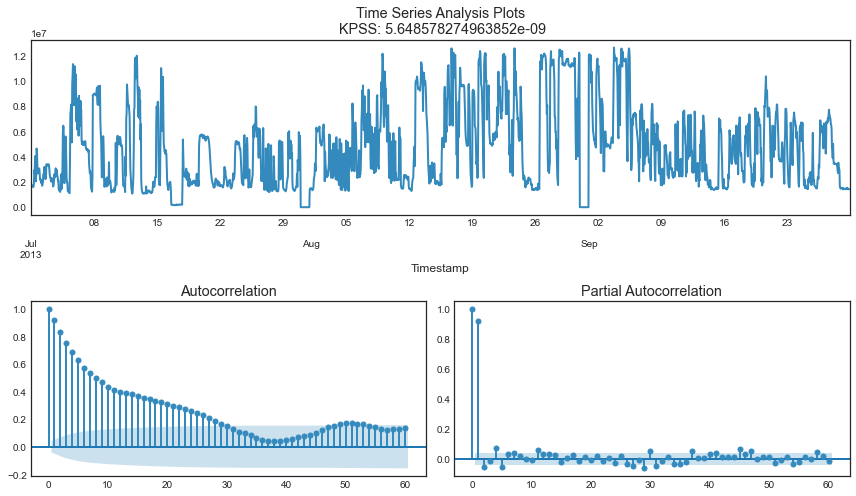

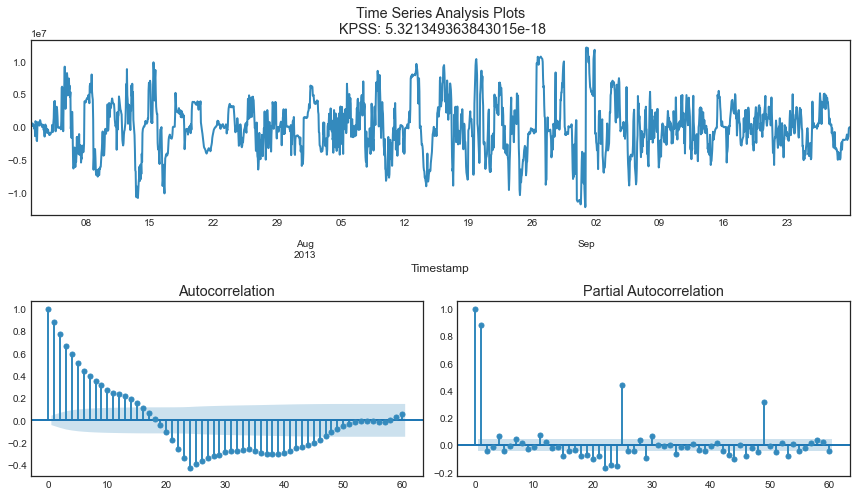

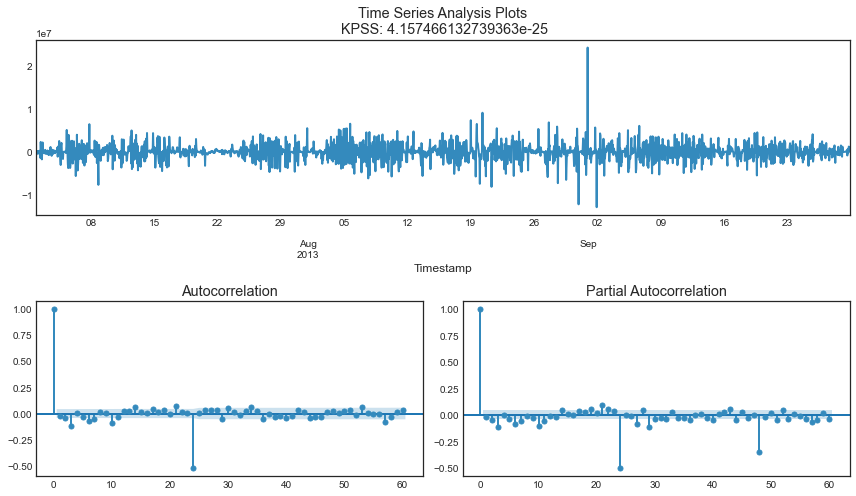

In [55]:
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)
ads_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=60)
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)


In [56]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        plt.style.use('seaborn-white')
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.kpss(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: '+ str(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

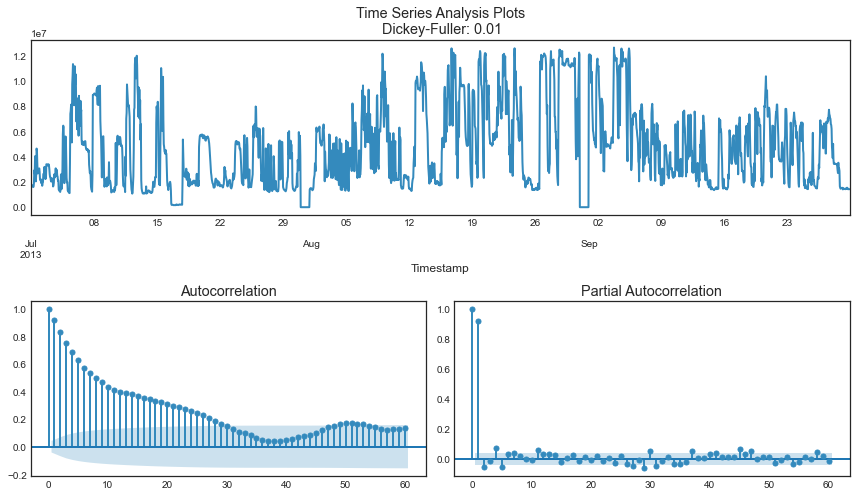

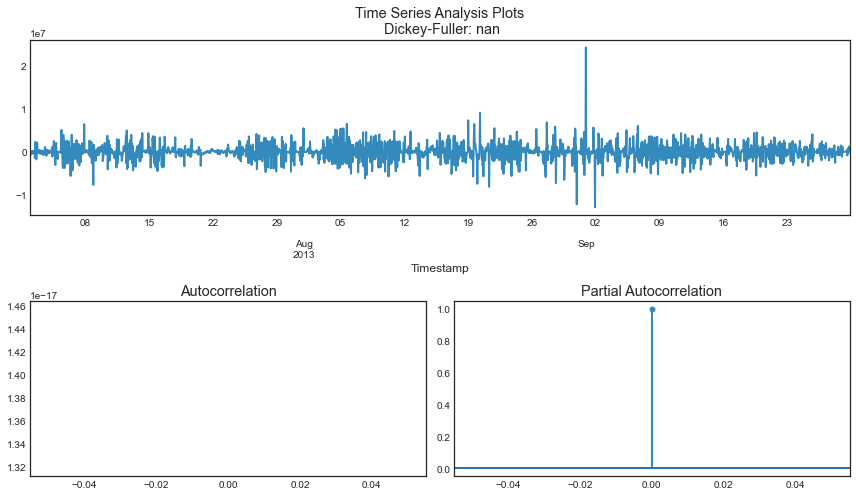

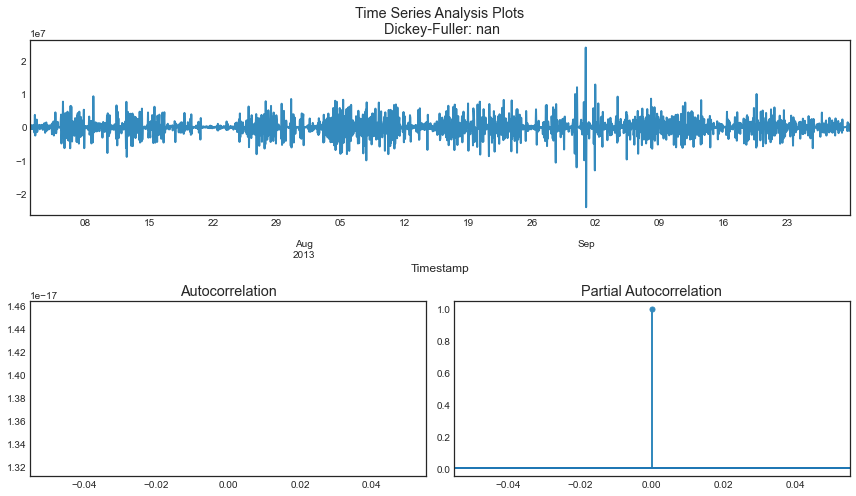

In [57]:
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)
kpss_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=60)
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)


### This indicates short time series

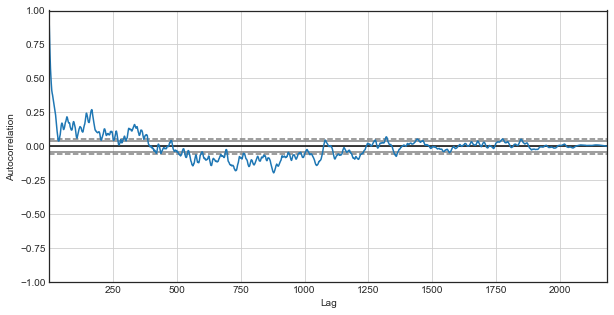

In [58]:
plt.figure(figsize=(10,5))
autocorrelation_plot(hourlydat['CPU usage [MHZ]']);
plt.show();


## MODULE 3 : MODELING

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import explained_variance_score
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

### Time Series Split

In [174]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    
 
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
   
    tscv = TimeSeriesSplit(n_splits=3) 
    
    
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [175]:
 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [176]:
def plotCoefficients(model):
   
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.tick_params(labelsize=20)
    plt.xlabel("Features", fontsize = 20) 
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [177]:
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]


for i in range(3, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)


### Plotting the model

In [95]:
from sklearn.metrics import mean_absolute_percentage_error as mapee

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    print (prediction)
    print(y_test)
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "orange", label="Prediction", linewidth=2.0)
    plt.plot(y_test.values,label="Actual Usage", linewidth=2.0)
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        print(mae)
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="Upper/Lower Bounds", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        plt.tick_params(labelsize=20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        plt.yticks([2000000,6000000,12000000, 50000000])# customized for graph readability
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    mape = mapee(y_test,prediction)
    error = mean_absolute_error(prediction,y_test)
    classifi = r2_score(y_test, prediction,multioutput='variance_weighted')
    mse =  mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    
   
    var = explained_variance_score(y_test, prediction)
    msle = mean_squared_log_error(y_test, prediction)
    print("Mean squared Error: "+ str(mse))
    print("Root mean squared error is: "+ str(rmse))
    print("Mean absolute percentage Error:{0:.2f}%".format(mape))
    print("Mean squared log error: {0:.2f}".format(msle))
    print("Explained variance score: {0:.2f}".format(var))     
    print("r2 score is {0:.2f}".format(classifi))
    print("Mean Absolute Error: {0:.2f}".format(error))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(mape),  fontsize = 20)
    plt.legend(loc="best", fontsize = 15)
    plt.tight_layout()
    plt.grid(True);

[ 5781129.08653496  5146941.24755753  5215719.15623703  5205979.11917027
  4892544.26956074  4588725.47552065  4338068.50316032  4566279.70417072
  4996848.65875205  5094583.81087147  4984987.53303817  4915720.43484217
  4575868.40149479  4751619.79216595  4831858.20054574  5149898.18760906
  5419036.94346472  5179446.7289308   5065993.99218506  5020470.49184453
  6837489.12235589  9145871.72652691 10630814.52699096 10284312.84605431
 10120162.06504181  9947581.39313592  9849712.82785359 10039997.05541605
  9896089.64345801  9634552.94614192  9014121.98412771  8851378.2434503
  7572126.53323331  5987025.22057732  5841781.55544031  7991600.5199684
  9926377.06700021 10080852.17650635  6603697.69892571  9590320.76739329
 10522966.82070091 10898125.6666219  11599802.541535    9944067.93404596
  8851191.36133442 10222342.92912303 10383347.34337902 10379039.51618143
 10148761.64437707  9835681.12391055  9851518.37114857 10279837.25351374
 10274242.77466466 10358362.58420343 10261810.2378400

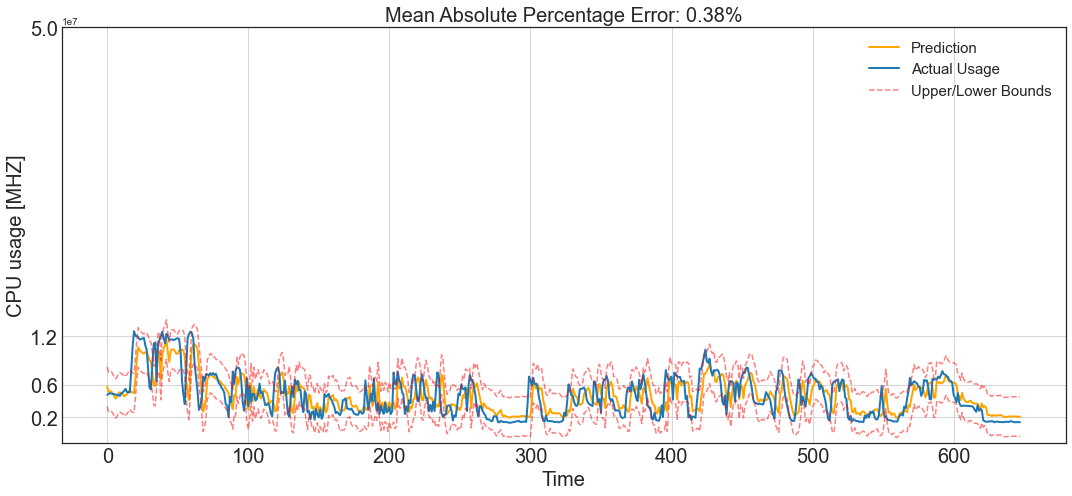

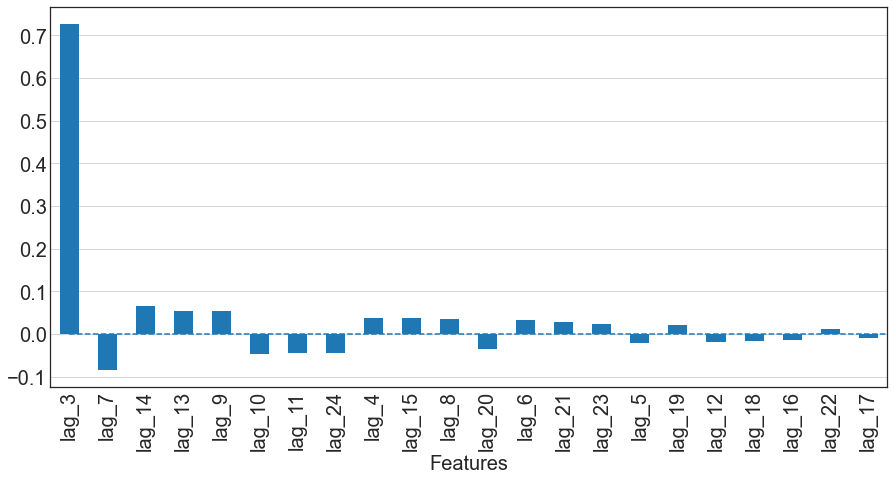

In [96]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


model = LinearRegression()
model.fit(X_train, y_train)

plotModelResults(model, plot_intervals=True)
plotCoefficients(model)


In [97]:
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

In [98]:
from sklearn.metrics import mean_absolute_percentage_error as mapee

def plotModelResultsScaler(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)

    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "orange", label="Prediction", linewidth=4.0)
    plt.plot(y_test.values,label="Actual Usage", linewidth=2.0)
    
   
    
    plt.ylabel("CPU usage [MHZ]", fontsize = 20)
    plt.xlabel("Time", fontsize = 20) 
   
    plt.tick_params(labelsize=20)
    plt.ylabel('CPU [MHz]  $e^{7}$', fontsize=20);
    plt.xlabel("Time", fontsize = 20) 
   
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "b--", label="Upper/Lower Bounds", alpha=0.5, linewidth=1)
        plt.plot(upper, "b--", alpha=0.5, linewidth=1)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    
    error = mean_absolute_error(y_test,prediction)
    classifi = r2_score(y_test, prediction,multioutput='variance_weighted')
    mse =  mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mape = mapee(y_test, prediction)
    var = explained_variance_score(y_test, prediction)
    msle = mean_squared_log_error(y_test, prediction)
    print("Mean squared Error: "+ str(mse))
    print("Root mean squared error is: "+ str(rmse))
    print("Mean absolute percentage Error: {0:.2f}%".format(mape))
    print("Mean squared log error: {0:.2f}".format(msle))
    print("Explained variance score: {0:.2f}".format(var))     
    print("r2 score is {0:.2f}".format(classifi))
    print("Mean Absolute Error: {0:.2f}".format(error))
    plt.title("Scaled linear Regression \n Mean Absolute Error {0:.2f}%".format(mape), fontsize = 20)
    plt.legend(loc="best", fontsize =15)
    plt.tight_layout()
    plt.grid(True);

In [99]:
hourlydat.head()


CPU cores  CPU capacity provisioned [MHZ]  \
Timestamp                                                        
2013-06-30 22:00:00      14040                    3.812018e+07   
2013-06-30 23:00:00      14040                    3.812018e+07   
2013-07-01 00:00:00      14040                    3.812018e+07   
2013-07-01 01:00:00      14040                    3.812018e+07   
2013-07-01 02:00:00      14040                    3.812018e+07   

                     CPU usage [MHZ]  CPU usage [%]  \
Timestamp                                             
2013-06-30 22:00:00     1.677022e+06   19372.219544   
2013-06-30 23:00:00     1.817519e+06   21302.382630   
2013-07-01 00:00:00     1.719936e+06   19897.298070   
2013-07-01 01:00:00     1.649799e+06   19546.600496   
2013-07-01 02:00:00     1.731963e+06   20524.195406   

                     Memory capacity provisioned [KB]  Memory usage [KB]  \
Timestamp                                                                  
2013-06-30 22:00:00                      4.871188e+10       1.855677e+09   
2013-06-30 23:00:00                      4.871215e+10       1.805727e+09   
2013-07-01 00:00:00                      4.871231e+10       1.742155e+09   
2013-07-01 01:00:00                      4.871278e+10       1.724193e+09   
2013-07-01 02:00:00                      4.871361e+10       1.782729e+09   

                     Disk read throughput [KB/s]  \
Timestamp                                          
2013-06-30 22:00:00                 7.029850e+05   
2013-06-30 23:00:00                 9.123973e+05   
2013-07-01 00:00:00                 9.670129e+05   
2013-07-01 01:00:00                 1.628856e+06   
2013-07-01 02:00:00                 1.413094e+06   

                     Disk write throughput [KB/s]  \
Timestamp                                           
2013-06-30 22:00:00                  4.193359e+05   
2013-06-30 23:00:00                  5.972818e+05   
2013-07-01 00:00:00                  1.122391e+06   
2013-07-01 01:00:00                  9.403050e+05   
2013-07-01 02:00:00                  1.108244e+06   

                     Network received throughput [KB/s]  \
Timestamp                                                 
2013-06-30 22:00:00                       183190.941026   
2013-06-30 23:00:00                       242444.979121   
2013-07-01 00:00:00                       279554.250216   
2013-07-01 01:00:00                       221960.783333   
2013-07-01 02:00:00                       194033.990476   

                     Network transmitted throughput [KB/s]  weekday  weekend  \
Timestamp                                                                      
2013-06-30 22:00:00                          342367.547436        6      1.0   
2013-06-30 23:00:00                          408352.440293        6      1.0   
2013-07-01 00:00:00                          479341.768398        0      0.0   
2013-07-01 01:00:00                          486785.550000        0      0.0   
2013-07-01 02:00:00                          347217.573810        0      0.0   

                     month  day  CPU usage prev    CPU_diff  received_prev  \
Timestamp                                                                    
2013-06-30 22:00:00      6   30    19414.112996  -43.393452  180831.050549   
2013-06-30 23:00:00      6   30    21076.695130  225.687500  241262.312454   
2013-07-01 00:00:00      7    1    20141.976542 -244.678472  277536.650216   
2013-07-01 01:00:00      7    1    19328.684524  217.915972  225730.983333   
2013-07-01 02:00:00      7    1    20509.355128   14.840278  193461.190476   

                     received_diff  transmitted_prev  transmitted_diff  
Timestamp                                                               
2013-06-30 22:00:00    2359.623810     326200.323626      16165.757143  
2013-06-30 23:00:00    1182.666667     408959.506960       -607.066667  
2013-07-01 00:00:00    2017.600000     473957.901732       5383.866667  
2013-07-01 01:0

### Scaled Linear Regression

Mean squared Error: 3442067640312.3003
Root mean squared error is: 1855281.0138392244
Mean absolute percentage Error: 0.36%
Mean squared log error: 0.17
Explained variance score: 0.50
r2 score is 0.50
Mean Absolute Error: 1374504.54


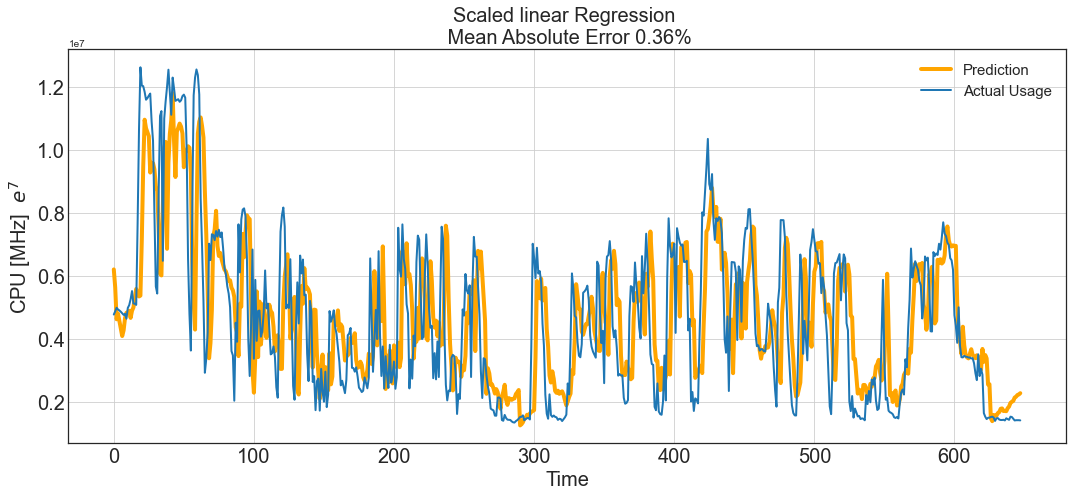

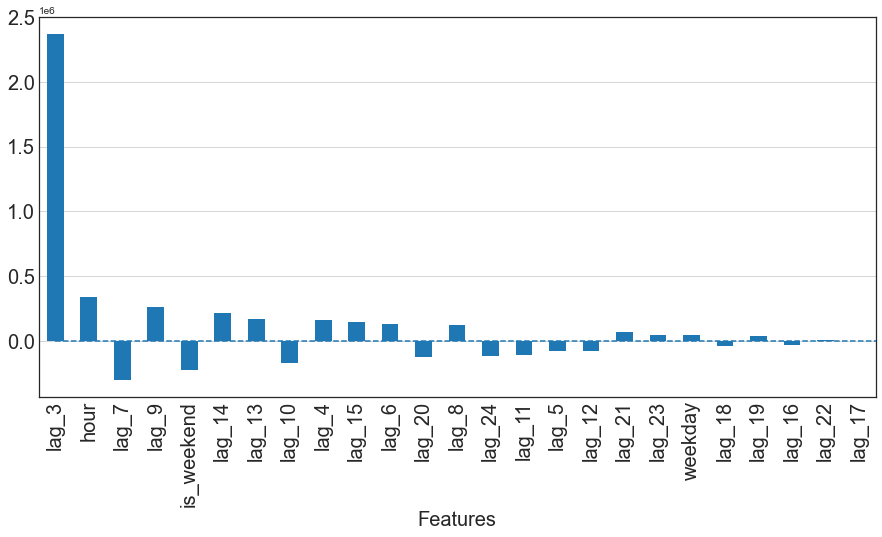

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr2, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=False, plot_anomalies=False)
plotCoefficients(lr2)

In [101]:
def code_mean(data, cat_feature, real_feature):
    
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
   
  
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    
    data['network received'] = hourlydat[['Network received throughput [KB/s]']]
    data['network transmitted'] = hourlydat[['Network transmitted throughput [KB/s]']]
    data['cpu diff'] = hourlydat[['CPU_diff']]
    data['received_prev'] = hourlydat[['received_prev']]
    data['core'] = hourlydat[['CPU cores']]

    if target_encoding:
        
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))
        
        
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
   
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)

    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

Mean squared Error: 6148651411232.782
Root mean squared error is: 2479647.4368814575
Mean absolute percentage Error: 0.67%
Mean squared log error: 0.36
Explained variance score: 0.15
r2 score is 0.09
Mean Absolute Error: 1978420.49


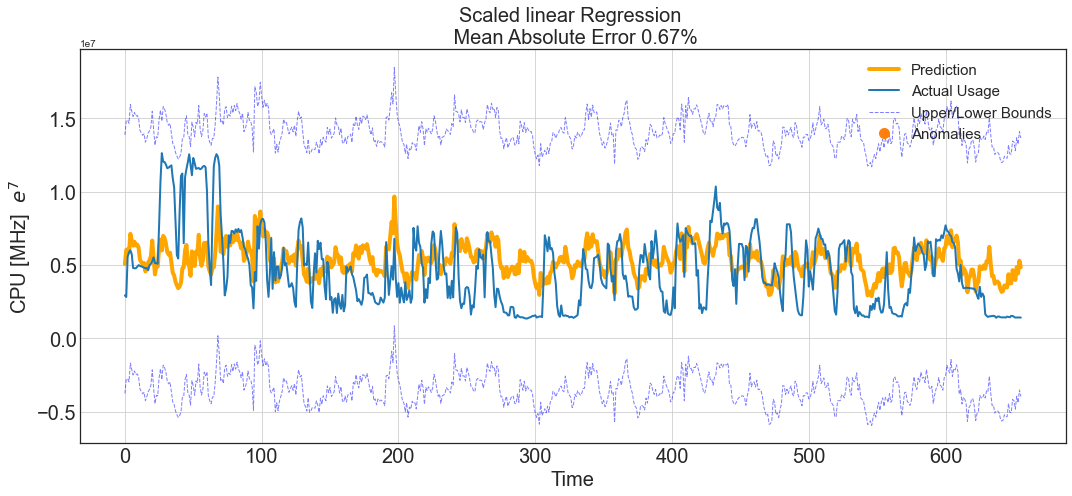

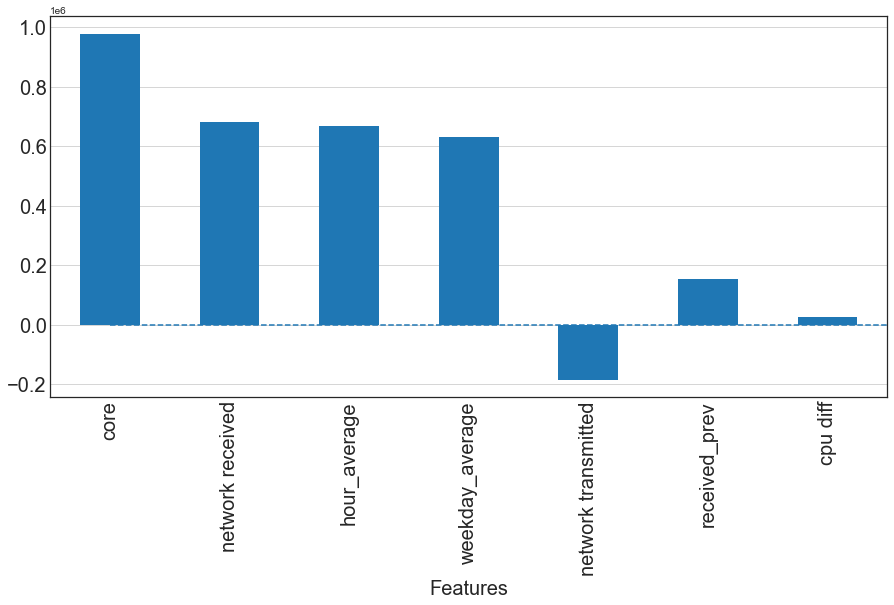

In [102]:
X_train, X_test, y_train, y_test =\
prepareData(hourlydat[['CPU usage [MHZ]']], lag_start=3, lag_end=3, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

### Ridge Regression

In [103]:
X_train, X_test, y_train, y_test =\
prepareData(hourlydat['CPU usage [MHZ]'], lag_start=3, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

       feature        VIF
0        lag_3  20.491391
1        lag_4  39.069874
2        lag_5  39.095046
3        lag_6  39.220654
4        lag_7  39.511744
5        lag_8  39.617895
6        lag_9  39.678032
7       lag_10  39.596390
8       lag_11  39.579634
9       lag_12  39.525431
10      lag_13  39.597484
11      lag_14  39.587604
12      lag_15  39.508672
13      lag_16  39.503234
14      lag_17  39.563656
15      lag_18  39.542140
16      lag_19  39.575441
17      lag_20  39.433208
18      lag_21  39.164599
19      lag_22  39.049988
20      lag_23  39.003911
21      lag_24  20.171771
22        hour   3.070158
23     weekday   7.172682
24  is_weekend   3.714826


In [81]:
X.drop(['lag_13'], axis=1, inplace=True)

In [401]:
X.drop(['lag_4'], axis=1, inplace=True)

KeyError: "['lag_4'] not found in axis"

In [402]:
X.drop(['lag_12','lag_5','lag_6'], axis=1, inplace=True)

KeyError: "['lag_12' 'lag_5' 'lag_6'] not found in axis"

In [403]:
X.drop(['lag_21','lag_22','lag_23','lag_14'], axis=1, inplace=True)

KeyError: "['lag_21' 'lag_22' 'lag_23' 'lag_14'] not found in axis"

Mean squared Error: 3198033472062.874
Root mean squared error is: 1788304.636258284
Mean absolute percentage Error: 0.38%
Mean squared log error: 0.17
Explained variance score: 0.54
r2 score is 0.53
Mean Absolute Error: 1367014.70


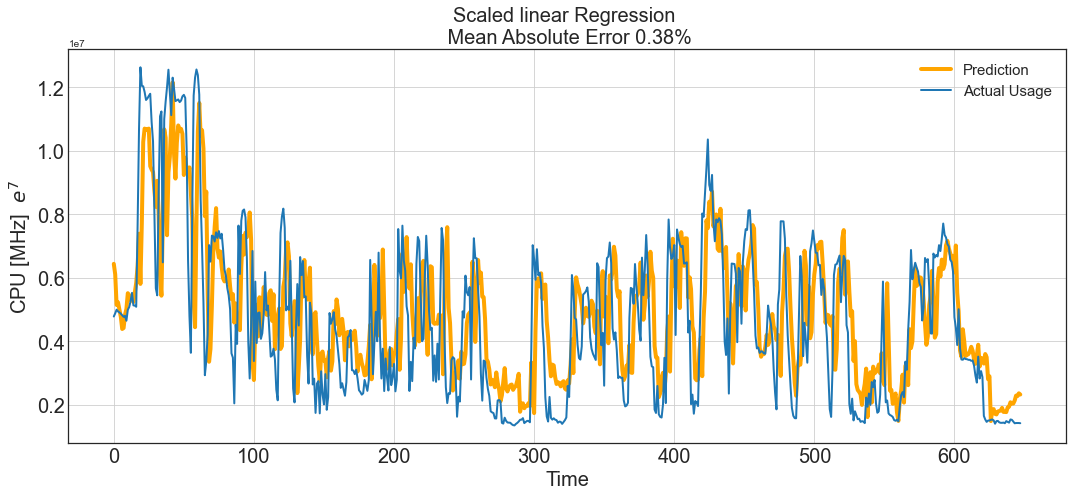

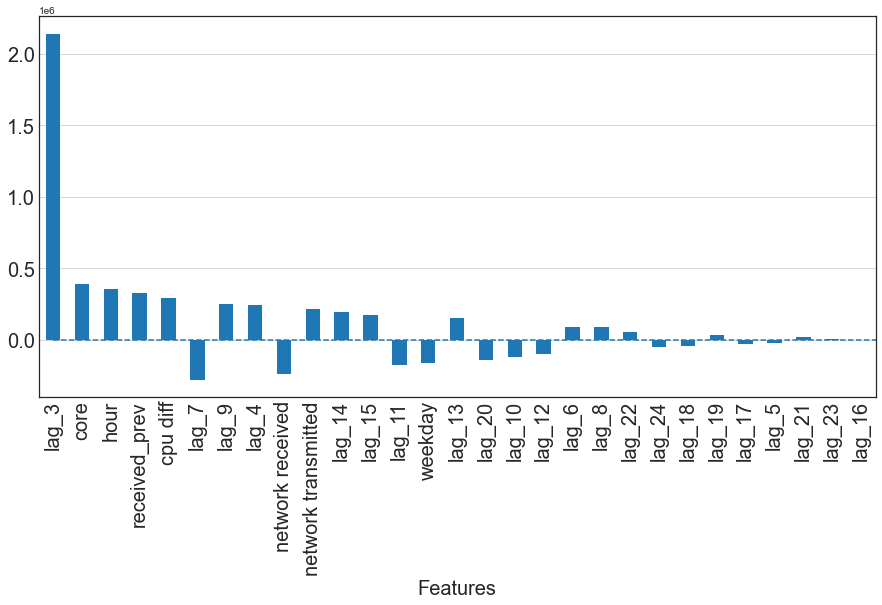

In [105]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResultsScaler(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=False, plot_anomalies=False)
plt.savefig('scaled_ridge_regression.png')

plotCoefficients(ridge)


<AxesSubplot:>

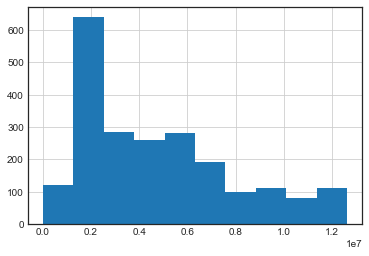

In [106]:
hourlydat['CPU usage [MHZ]'].hist()

In [107]:
from scipy.stats import norm
from scipy.stats import shapiro
my_data = norm.rvs(hourlydat['CPU usage [MHZ]'])
shapiro(my_data)

(0.9212614893913269, 2.4314742120982016e-32)

### Lasso Regression

Mean squared Error: 3152490935565.777
Root mean squared error is: 1775525.537852322
Mean absolute percentage Error: 0.39%
Mean squared log error: 0.17
Explained variance score: 0.54
r2 score is 0.54
Mean Absolute Error: 1374554.10


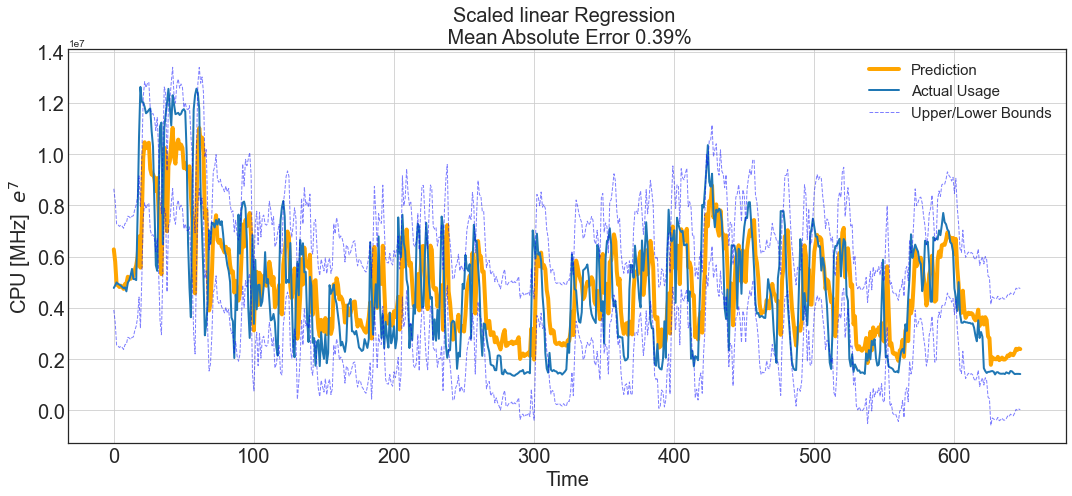

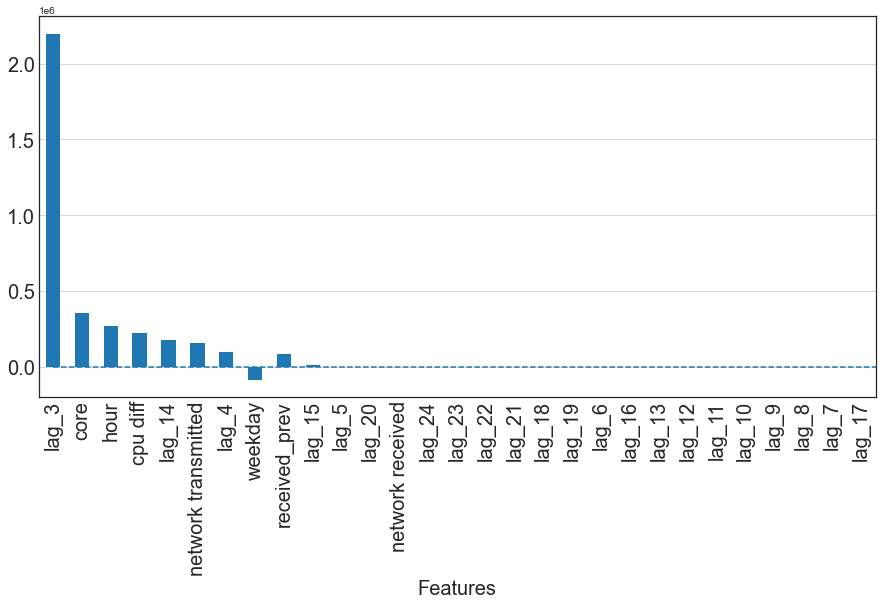

In [108]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResultsScaler(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=False)
plt.savefig('scaled_lasso_regression.png')
plotCoefficients(lasso)

In [198]:
def tsplot_qq(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

array([[<AxesSubplot:title={'center':'lag_3'}>,
        <AxesSubplot:title={'center':'lag_4'}>,
        <AxesSubplot:title={'center':'lag_5'}>,
        <AxesSubplot:title={'center':'lag_6'}>,
        <AxesSubplot:title={'center':'lag_7'}>],
       [<AxesSubplot:title={'center':'lag_8'}>,
        <AxesSubplot:title={'center':'lag_9'}>,
        <AxesSubplot:title={'center':'lag_10'}>,
        <AxesSubplot:title={'center':'lag_11'}>,
        <AxesSubplot:title={'center':'lag_12'}>],
       [<AxesSubplot:title={'center':'lag_13'}>,
        <AxesSubplot:title={'center':'lag_14'}>,
        <AxesSubplot:title={'center':'lag_15'}>,
        <AxesSubplot:title={'center':'lag_16'}>,
        <AxesSubplot:title={'center':'lag_17'}>],
       [<AxesSubplot:title={'center':'lag_18'}>,
        <AxesSubplot:title={'center':'lag_19'}>,
        <AxesSubplot:title={'center':'lag_20'}>,
        <AxesSubplot:title={'center':'lag_21'}>,
        <AxesSubplot:title={'center':'lag_22'}>],
       [<AxesSubplot:ti

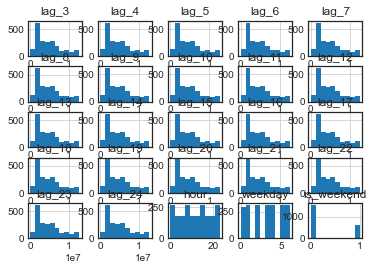

In [204]:
import pandas as pd
my_data = X
my_data.hist()

In [ ]:

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot_qq(x,lags=30)

In [120]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(\
    maxlag=30, ic='aic', trend='nc')

Wall time: 15.3 s


In [121]:
true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


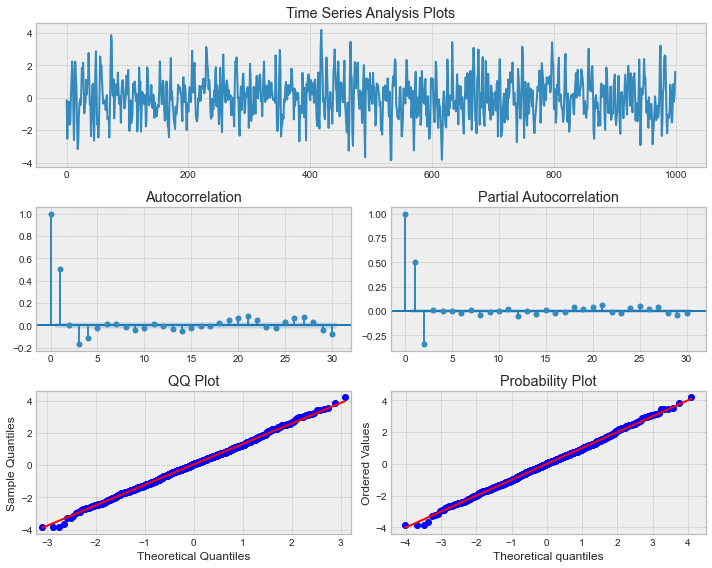

In [122]:
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot_qq(ar2, lags=30)

In [123]:
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


In [145]:
data = hourlydat
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [146]:
lrets = np.log(data/data.shift(1)).dropna()

In [150]:
max_lag = 30
mdl = smt.AR(lrets['CPU usage [MHZ]']).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets['CPU usage [MHZ]']).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = {}'.format(est_order))

best estimated lag order = 3


### Differencing CPU usage

<Figure size 1080x360 with 0 Axes>

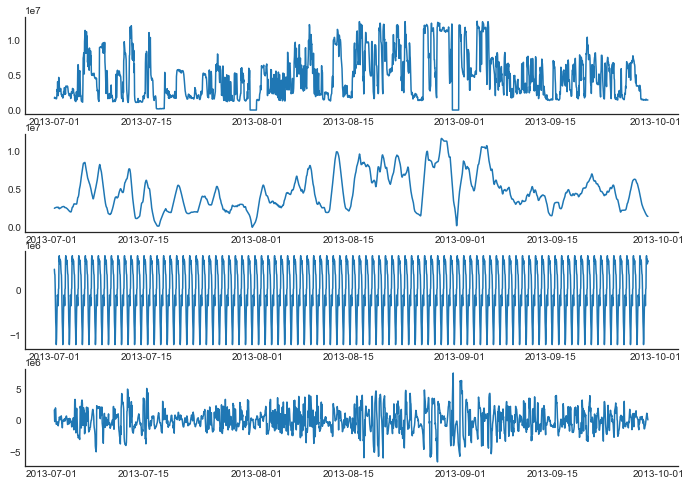

In [72]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



decomp = seasonal_decompose(hourlydat['CPU usage [MHZ]'], model="additive")

plt.figure(figsize=(15,5))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(11.7, 8.27)

ax1.plot(hourlydat['CPU usage [MHZ]'])
ax2.plot(decomp.trend)
ax3.plot(decomp.seasonal)
ax4.plot(decomp.resid)
sns.despine()

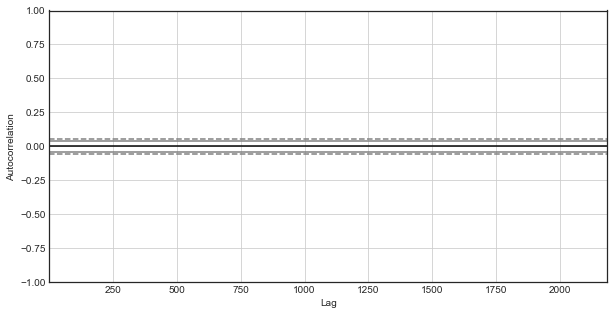

In [73]:
plt.figure(figsize=(10,5))
autocorrelation_plot(decomp.resid);
plt.show();

In [74]:
dftest = adfuller(hourlydat['CPU usage [MHZ]'], autolag='AIC')

# formats stats output
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                -6.633146e+00
p-value                        5.648578e-09
# of Lags Used                 1.200000e+01
Number of Observations Used    2.171000e+03
Critical Value (1%)           -3.433366e+00
Critical Value (5%)           -2.862872e+00
Critical Value (10%)          -2.567479e+00
dtype: float64


In [75]:
resid = decomp.resid.dropna()
decomp_adf = adfuller(resid, autolag='AIC')
adf_output(decomp_adf)

Test Statistic                -1.305650e+01
p-value                        2.089546e-24
# of Lags Used                 2.600000e+01
Number of Observations Used    2.133000e+03
Critical Value (1%)           -3.433419e+00
Critical Value (5%)           -2.862896e+00
Critical Value (10%)          -2.567492e+00
dtype: float64


Test Statistic                -1.779734e+01
p-value                        3.228679e-30
# of Lags Used                 1.200000e+01
Number of Observations Used    2.170000e+03
Critical Value (1%)           -3.433367e+00
Critical Value (5%)           -2.862873e+00
Critical Value (10%)          -2.567480e+00
dtype: float64


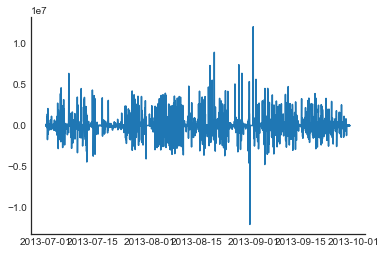

In [76]:
diffed = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift()
diffed.dropna(inplace=True)
plt.plot(diffed)
sns.despine()
diffed_adf = adfuller(diffed, autolag='AIC')
adf_output(diffed_adf)

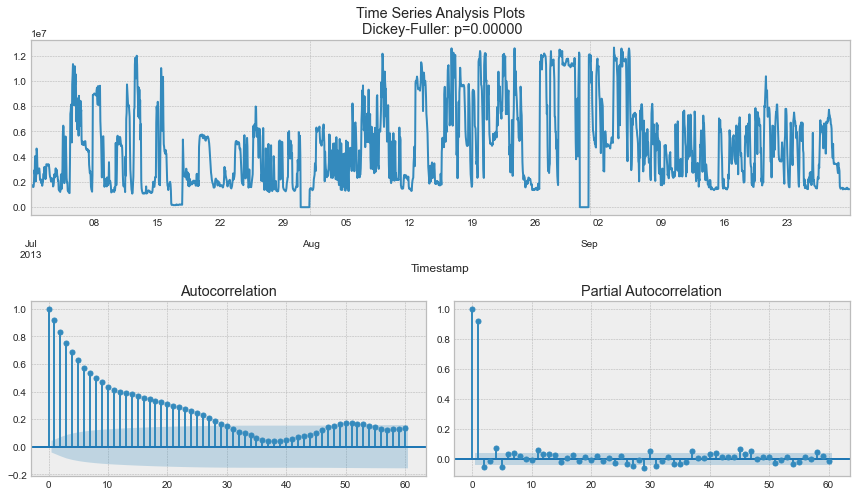

In [77]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)

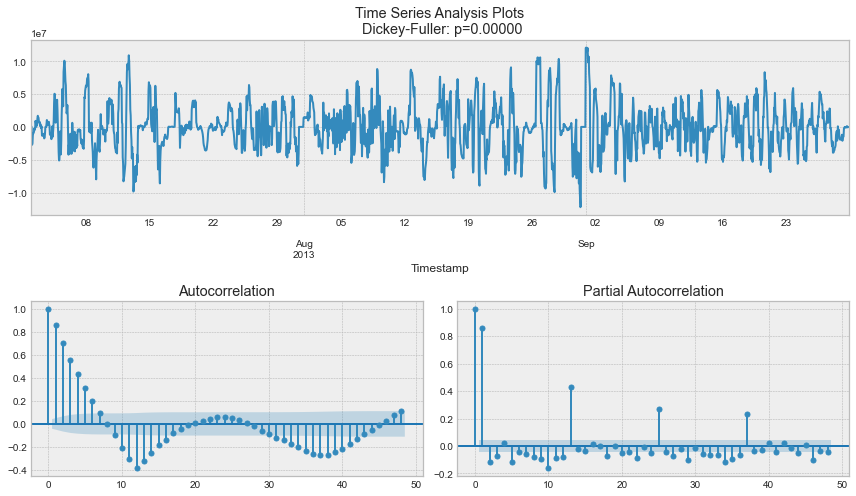

In [78]:
standardizeddf_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(12)
tsplot(standardizeddf_diff[24:], lags=48)


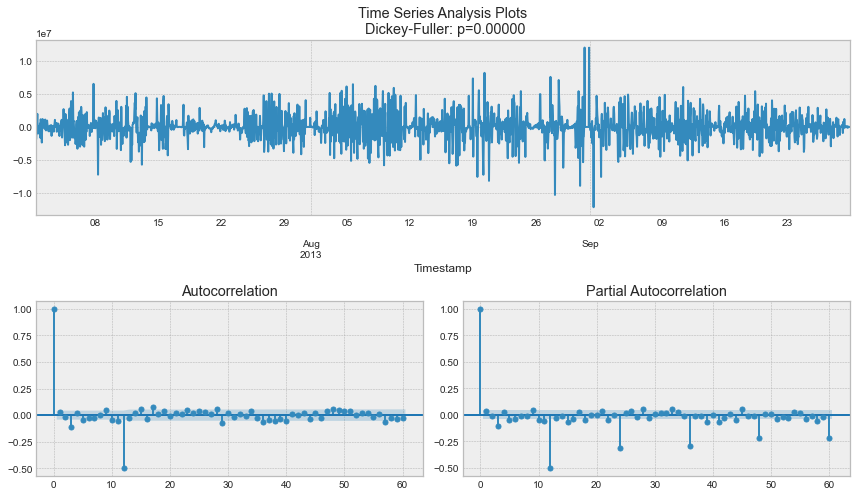

In [79]:
standardizeddf_diff = standardizeddf_diff - standardizeddf_diff.shift(1)
tsplot(standardizeddf_diff[12+1:], lags=60)

### ARIMA model

                             ARIMA Model Results                              
Dep. Variable:      D.CPU usage [MHZ]   No. Observations:                 2183
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -33772.948
Method:                       css-mle   S.D. of innovations        1266292.521
Date:                Sun, 06 Jun 2021   AIC                          67561.896
Time:                        12:49:03   BIC                          67607.403
Sample:                    06-30-2013   HQIC                         67578.531
                         - 09-29-2013                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -116.4533   2132.269     -0.055      0.956   -4295.623    4062.716
ar.L1.D.CPU usage [MHZ]     0.9554      0.022     44.287      0.000       0.913       0.998


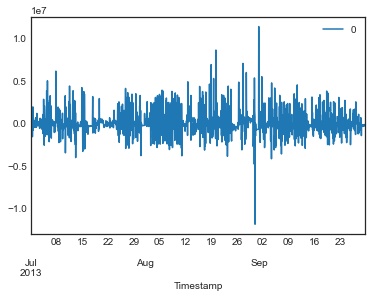

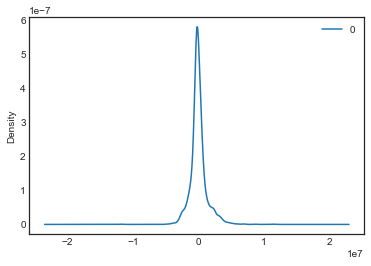

                  0
count  2.183000e+03
mean   7.890254e+03
std    1.266701e+06
min   -1.187764e+07
25%   -4.889638e+05
50%   -1.353515e+05
75%    3.923363e+05
max    1.134292e+07


NameError: name 'tsplot_qq' is not defined

In [365]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# fit model
model = ARIMA(hourlydat['CPU usage [MHZ]'], order=(5,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())
_ = tsplot_qq(model.resid, lags=30)

aic: 67559.62588 | order: (1, 1, 5)


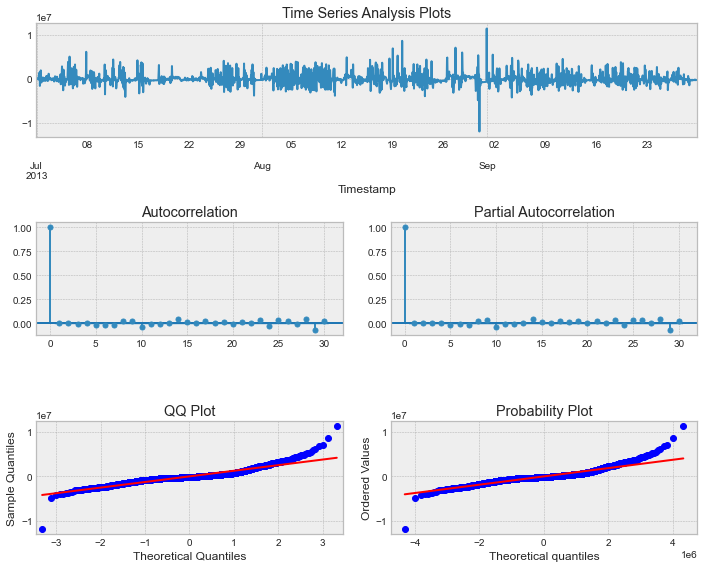

In [493]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(6) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(hourlydat['CPU usage [MHZ]'], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot_qq(best_mdl.resid, lags=30)

In [382]:
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
 

X = hourlydat['CPU usage [MHZ]']

size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))



predicted=3080365.546554, expected=2931490.855170
predicted=3495696.555844, expected=2824417.954877
predicted=3130879.561167, expected=5554523.554445
predicted=5667333.140884, expected=5876949.360360
predicted=6100176.292410, expected=6004642.198949
predicted=5930775.580510, expected=5745079.790443
predicted=6116310.873042, expected=4804260.447126
predicted=4995236.595914, expected=4777999.352233
predicted=5026855.331614, expected=4782257.202540
predicted=5093226.931393, expected=4882034.649354
predicted=5025976.470243, expected=4995857.960450
predicted=5214046.659468, expected=4941506.735666
predicted=5148929.106481, expected=4911415.638863
predicted=5127038.232986, expected=4871059.950129
predicted=5103208.239950, expected=4823155.699529
predicted=5040425.742616, expected=4771202.715666
predicted=4994727.652753, expected=4804027.339429
predicted=5028456.872774, expected=4649025.439039
predicted=4875527.561523, expected=4991103.601681
predicted=5207278.622272, expected=5080442.633511


In [386]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_error(test,predictions)
classifi = r2_score(test, predictions,multioutput='variance_weighted')
mse =  mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions, squared=False)

test = test.reshape(-1, 1)
mape = mean_absolute_percentage_error(test, predictions)
var = explained_variance_score(test, predictions)
#msle = mean_squared_log_error(test, predictions)
print("Mean squared Error: "+ str(mse))
print("Root mean squared error is: "+ str(rmse))
print("Mean absolute percentage Error: {0:.2f}%".format(mape))
#print("Mean squared log error: {0:.2f}".format(msle))
print("Explained variance score: {0:.2f}".format(var))     

print("r2 score is {0:.2f}".format(classifi))
print("Mean Absolute Error: {0:.2f}".format(error))


Mean squared Error: 1302180401957.3877
Root mean squared error is: 1141131.1940164408
Mean absolute percentage Error: 20.80%
Explained variance score: 0.81
r2 score is 0.81
Mean Absolute Error: 805308.58


In [550]:
hourlydat['CPU usage [MHZ]'].head(24)

Timestamp
2013-06-30 22:00:00    1.677022e+06
2013-06-30 23:00:00    1.817519e+06
2013-07-01 00:00:00    1.719936e+06
2013-07-01 01:00:00    1.649799e+06
2013-07-01 02:00:00    1.731963e+06
2013-07-01 03:00:00    1.667130e+06
2013-07-01 04:00:00    1.626906e+06
2013-07-01 05:00:00    1.592491e+06
2013-07-01 06:00:00    1.621074e+06
2013-07-01 07:00:00    1.923474e+06
2013-07-01 08:00:00    2.919916e+06
2013-07-01 09:00:00    2.639690e+06
2013-07-01 10:00:00    4.034222e+06
2013-07-01 11:00:00    2.313831e+06
2013-07-01 12:00:00    2.041863e+06
2013-07-01 13:00:00    2.572665e+06
2013-07-01 14:00:00    4.638736e+06
2013-07-01 15:00:00    4.431054e+06
2013-07-01 16:00:00    3.387118e+06
2013-07-01 17:00:00    2.665557e+06
2013-07-01 18:00:00    2.828378e+06
2013-07-01 19:00:00    2.727257e+06
2013-07-01 20:00:00    2.833081e+06
2013-07-01 21:00:00    3.069166e+06
Freq: H, Name: CPU usage [MHZ], dtype: float64

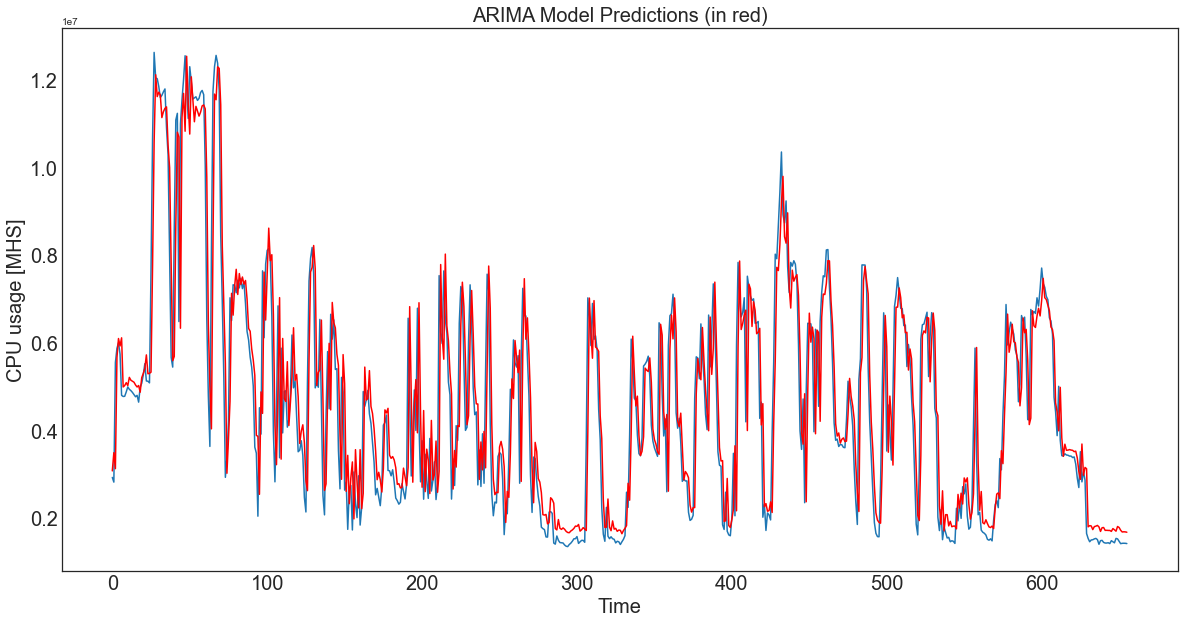

In [384]:
testnew = test
#testnew= testnew.reset_index(drop = True)
prednew = pd.Series( (v[0] for v in predictions) )
plt.figure(figsize=(20,10))
plt.plot(testnew)
plt.plot(prednew, color='red')
plt.tick_params(labelsize=20)
plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
plt.ylabel("CPU usage [MHS]", fontsize = 20)
plt.xlabel("Time", fontsize = 20)
plt.show();

### HOLT WINTERS MODEL

In [380]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [344]:
# Standardize time series data
from pandas import Series
from sklearn.preprocessing import StandardScaler
from math import sqrt
# load the dataset and print the first 5 rows
# prepare data for standardization
values = hourlydat['CPU usage [MHZ]']
values = values.values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
    print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
    print(inversed[i])

Mean: 4699483.242110, StandardDeviation: 3177434.649794
[-0.95122698]
[-0.90700962]
[-0.93772111]
[-0.95979441]
[-0.93393586]
[1677021.660339]
[1817519.45998964]
[1719935.68365985]
[1649799.21903881]
[1731963.07391202]


In [345]:
class HoltWinters:

   
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [346]:

from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [362]:
data = hourlydat['CPU usage [MHZ]'][:-20] # leave some data for testing

x = [0.1,0,0.9] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 60, scaling_factor =3)
model.triple_exponential_smoothing()

0.0792941687295633 0.0 0.0


Mean squared Error: 2415004999851.2866
Root mean squared error is: 2067175.1820788688
Mean absolute percentage Error: 41.68%
Explained variance score: 0.26
r2 score is 0.26
Mean Absolute Error: 1554028.64


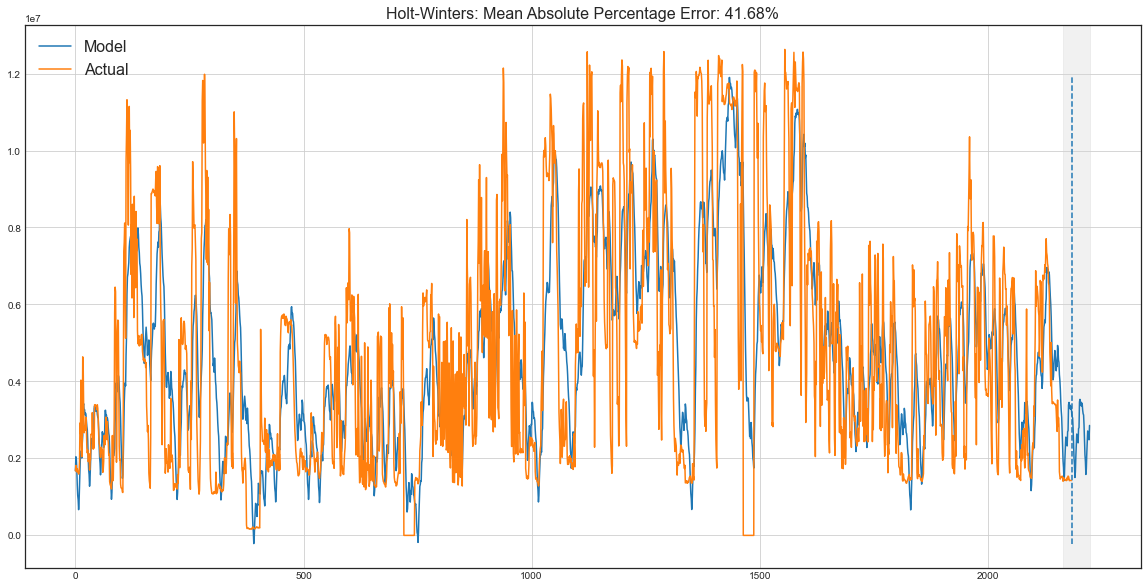

In [363]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
        
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_error(series.values, model.result[:len(series)])
    classifi = r2_score(model.result[:len(series)], series.values,multioutput='variance_weighted')
    mse =  mean_squared_error(model.result[:len(series)], series.values)
 #   rmse = mean_squared_error(model.result[:len(series)], series.values, squared=False)
    mape = mean_absolute_percentage_error(model.result[:len(series)], series.values)
    var = explained_variance_score(model.result[:len(series)], series.values)
#    msle = mean_squared_log_error(model.result[:len(series)], series.values)
    print("Mean squared Error: "+ str(mse))
    print("Root mean squared error is: "+ str(rmse))
    print("Mean absolute percentage Error: {0:.2f}%".format(mape))
#   print("Mean squared log error: {0:.2f}".format(msle))
    print("Explained variance score: {0:.2f}".format(var))     
    print("r2 score is {0:.2f}".format(classifi))
    print("Mean Absolute Error: {0:.2f}".format(error))
    plt.title("Holt-Winters: Mean Absolute Percentage Error: {0:.2f}%".format(mape), fontsize = 16)
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=16);
    
plotHoltWinters(hourlydat['CPU usage [MHZ]'])
#plotHoltWinters(hourlydat['CPU usage [MHZ]'], plot_intervals=True, plot_anomalies=True)

# SARIMA MODEL

In [391]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

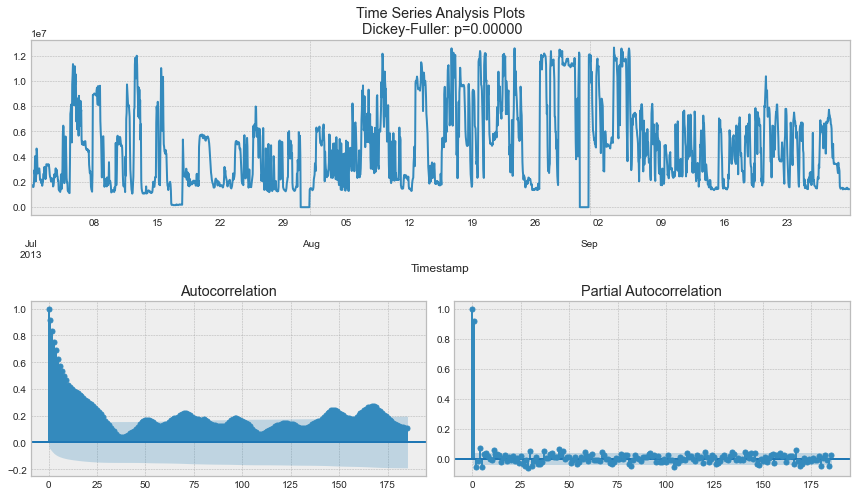

In [392]:
tsplot(hourlydat['CPU usage [MHZ]'], lags=185)

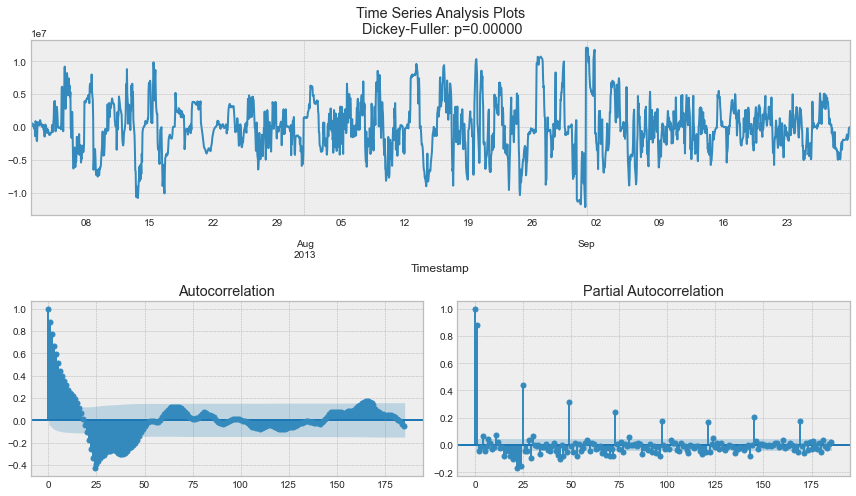

In [393]:
ads_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=185)

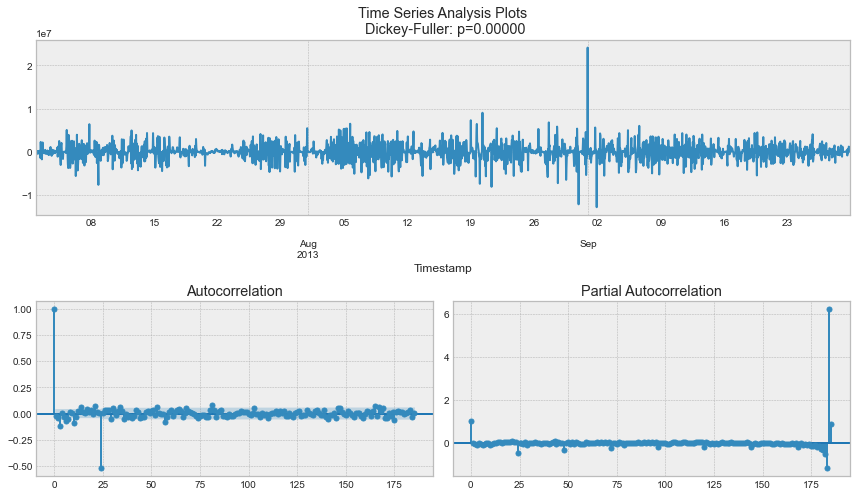

In [394]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=185)

In [84]:
# setting initial values and some bounds for them based on ACF and PACF
ps = range(0, 6)
d=1 
qs = range(0, 6)
Ps = range(0, 3)
D=1 
Qs = range(0, 3)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


324

In [85]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """  
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimizeSARIMA(parameters_list, d, D, s)


  0%|          | 0/324 [00:00<?, ?it/s]

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/324 [00:00<?, ?it/s]

In [ ]:
result_table.head(10)

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

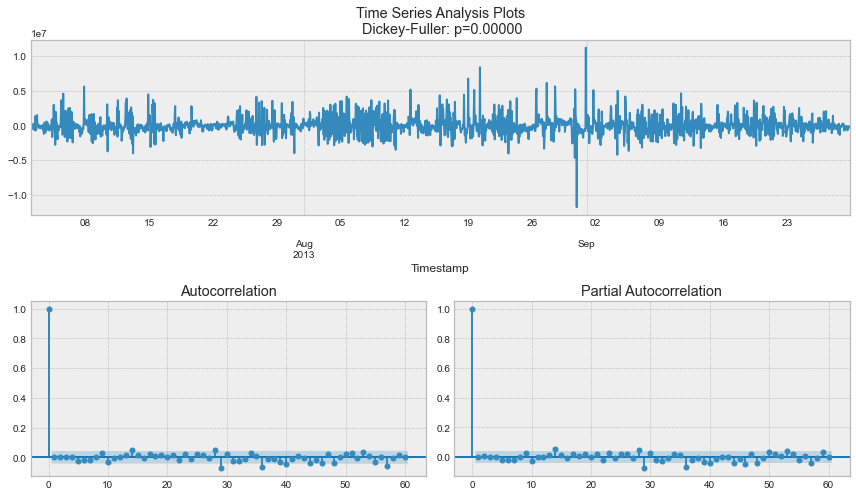

In [564]:
tsplot(best_model.resid[24+1:], lags=60)


In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
        
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_error(series.values, model.result[:len(series)])
    classifi = r2_score(model.result[:len(series)], series.values,multioutput='variance_weighted')
    mse =  mean_squared_error(model.result[:len(series)], series.values)
    rmse = mean_squared_error(model.result[:len(series)], series.values, squared=False)
    mape = mean_absolute_percentage_error(model.result[:len(series)], series.values)
    var = explained_variance_score(model.result[:len(series)], series.values)
    print("Mean squared Error: "+ str(mse))
    print("Root mean squared error is: "+ str(rmse))
    print("Mean absolute percentage Error: {0:.2f}%".format(mape))
    print("Explained variance score: {0:.2f}".format(var))     
    print("r2 score is {0:.2f}".format(classifi))
    print("Mean Absolute Error: {0:.2f}".format(error))
    plt.title("Holt-Winters: Mean Absolute Percentage Error: {0:.2f}%".format(mape), fontsize = 16)
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=16);
    
plotHoltWinters(hourlydat['CPU usage [MHZ]'])

In [578]:
def plotSARIMA(series, model):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = hourlydat['CPU usage [MHZ]']
    data['arima_model'] = model.fittedvalues
    
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0])
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
  #  error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

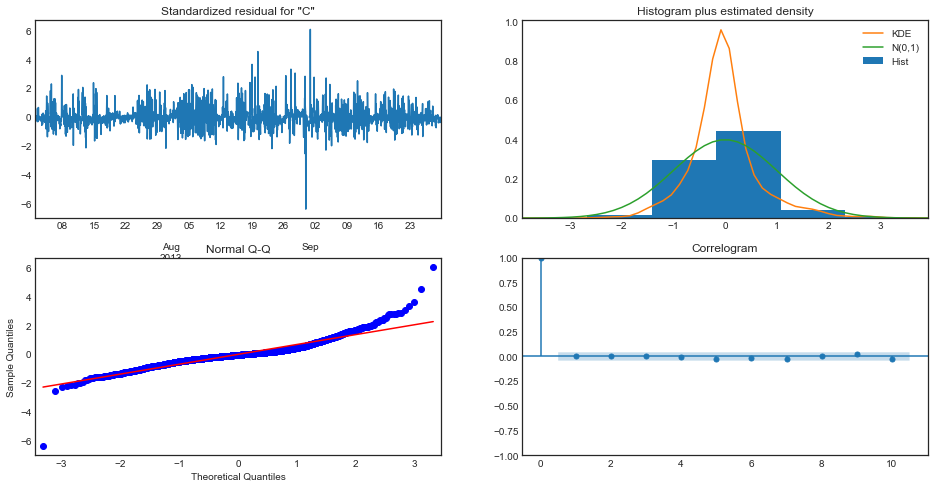

In [580]:
best_model.plot_diagnostics(figsize=(16, 8))
plt.show()

ConversionError: Failed to convert value(s) to axis units: ['arima_model', Timestamp('2013-09-29 23:00:00')]

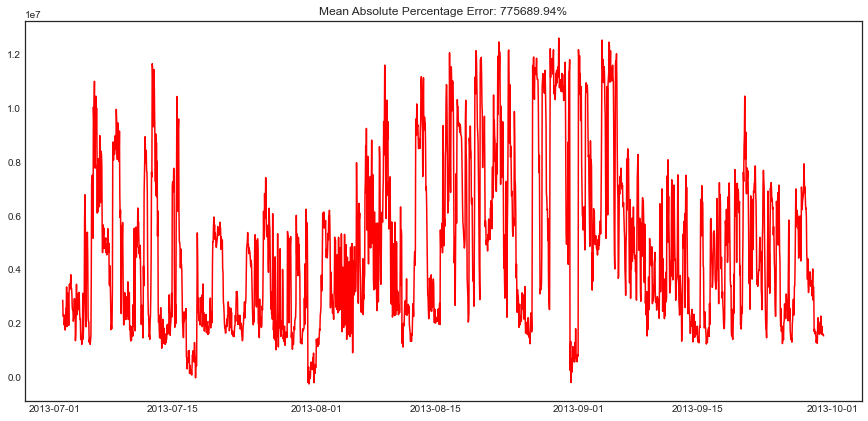

In [579]:

plotSARIMA(hourlydat['CPU usage [MHZ]'], best_model)

In [586]:
import itertools

In [ ]:
# load required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(X,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [587]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(5,1,1),
                                seasonal_order=(5, 1, [1], 24),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
#res = mdl.fit()
#The summary- look at table of coefficients.
res = mdl.fit()
print(res.summary().tables[1])

# print statistics
print(res.aic)
print(res.summary())


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2779      0.229     -1.215      0.224      -0.726       0.170
ar.L2         -0.1237      0.140     -0.883      0.377      -0.398       0.151
ar.L3          0.2008      0.160      1.255      0.209      -0.113       0.514
ar.L4          0.7964      0.183      4.361      0.000       0.438       1.154
ma.L1          0.1967      0.237      0.831      0.406      -0.267       0.661
ma.L2          0.0290      0.165      0.176      0.860      -0.294       0.352
ma.L3         -0.3422      0.159     -2.146      0.032      -0.655      -0.030
ma.L4         -0.8546      0.220     -3.888      0.000      -1.285      -0.424
ar.S.L24      -0.0921      0.043     -2.141      0.032      -0.176      -0.008
ma.S.L24      -0.9357      0.033    -28.142      0.000      -1.001      -0.871
sigma2      3.802e+12   2.29e-14   1.66e+26      0.0

In [588]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(4, 1, 4),
                                seasonal_order=(1, 1, [1], 24),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

print(res.summary().tables[1])
 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2779      0.229     -1.215      0.224      -0.726       0.170
ar.L2         -0.1237      0.140     -0.883      0.377      -0.398       0.151
ar.L3          0.2008      0.160      1.255      0.209      -0.113       0.514
ar.L4          0.7964      0.183      4.361      0.000       0.438       1.154
ma.L1          0.1967      0.237      0.831      0.406      -0.267       0.661
ma.L2          0.0290      0.165      0.176      0.860      -0.294       0.352
ma.L3         -0.3422      0.159     -2.146      0.032      -0.655      -0.030
ma.L4         -0.8546      0.220     -3.888      0.000      -1.285      -0.424
ar.S.L24      -0.0921      0.043     -2.141      0.032      -0.176      -0.008
ma.S.L24      -0.9357      0.033    -28.142      0.000      -1.001      -0.871
sigma2      3.802e+12   2.29e-14   1.66e+26      0.0

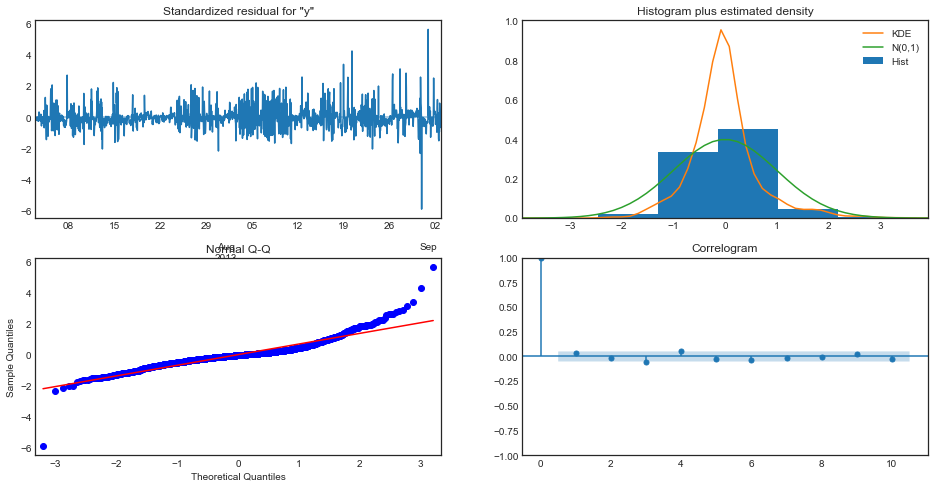

In [589]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [700]:
p = d = q = range(0, 6)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

In [395]:

mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(5,1,1),
                                seasonal_order=(5,1,0, 24),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
#res = mdl.fit()
#The summary- look at table of coefficients.
res = mdl.fit()


print(res.summary().tables[1]) 



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9627      0.046     20.855      0.000       0.872       1.053
ar.L2         -0.0631      0.066     -0.959      0.337      -0.192       0.066
ar.L3         -0.0788      0.070     -1.120      0.263      -0.217       0.059
ar.L4          0.1776      0.067      2.667      0.008       0.047       0.308
ar.L5         -0.0956      0.042     -2.262      0.024      -0.178      -0.013
ma.L1         -0.9982      0.010    -99.563      0.000      -1.018      -0.979
ar.S.L24      -0.9032      0.030    -30.132      0.000      -0.962      -0.844
ar.S.L48      -0.7145      0.056    -12.862      0.000      -0.823      -0.606
ar.S.L72      -0.5464      0.069     -7.903      0.000      -0.682      -0.411
ar.S.L96      -0.3427      0.069     -4.995      0.000      -0.477      -0.208
ar.S.L120     -0.1826      0.055     -3.332      0.0

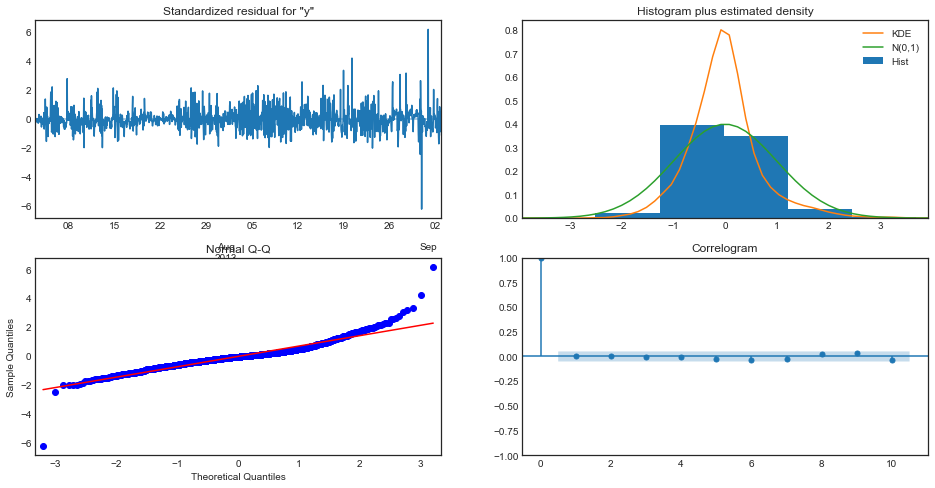

In [396]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [149]:
df =hourlydat['CPU usage [MHZ]']

In [425]:
print(y_forecasted.shape)

(46,)


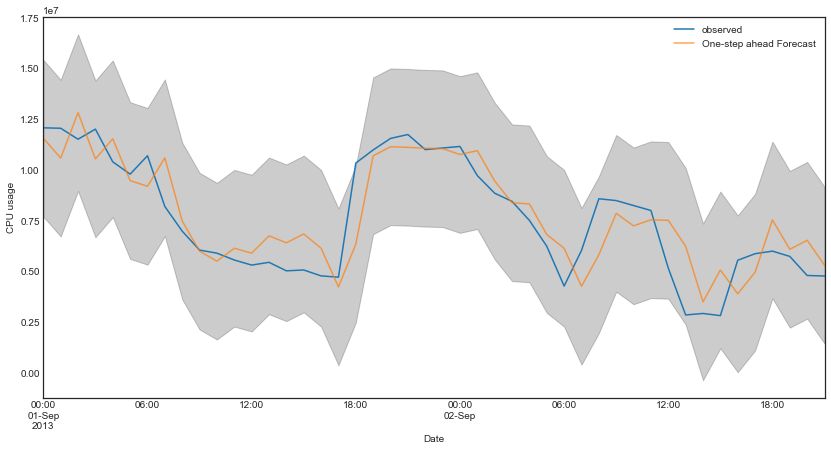

0.7426865943725826
1421881.4321458202
1118368.2137324752
Mean absolute percentage Error: 18.95%


In [442]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
pred = res.get_prediction(start=pd.to_datetime('2013-09-01'))
pred_ci = pred.conf_int()

ax = df['2013-09-01':'2013-09-02 21:00:00'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CPU usage')
plt.legend()

plt.show()
y_truth = df['2013-09-01':'2013-09-02 21:00:00']
y_forecasted=pred.predicted_mean
mape = mean_absolute_percentage_error( y_truth,y_forecasted)
r2 = r2_score(y_truth,y_forecasted)
rmse = mean_squared_error(y_truth,y_forecasted, squared=False)
mse = mean_squared_error(y_truth,y_forecasted)
mae = mean_absolute_error(y_truth,y_forecasted)
print(str(r2))
print(str(rmse))
print(str(mae))
print("Mean absolute percentage Error: {0:.2f}%".format(mape))


In [124]:
df =hourlydat['CPU usage [MHZ]']
df['2013':]

Timestamp
2013-06-30 22:00:00    1.677022e+06
2013-06-30 23:00:00    1.817519e+06
2013-07-01 00:00:00    1.719936e+06
2013-07-01 01:00:00    1.649799e+06
2013-07-01 02:00:00    1.731963e+06
                           ...     
2013-09-29 17:00:00    1.420654e+06
2013-09-29 18:00:00    1.428400e+06
2013-09-29 19:00:00    1.429791e+06
2013-09-29 20:00:00    1.428487e+06
2013-09-29 21:00:00    1.422804e+06
Freq: H, Name: CPU usage [MHZ], Length: 2184, dtype: float64

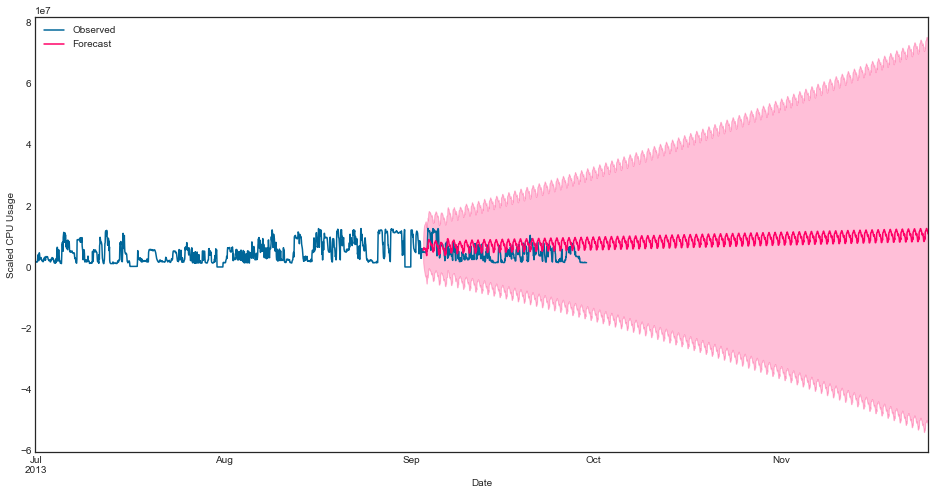

In [164]:
pred_uc = res.get_forecast(steps=2000)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = df.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Scaled CPU Usage');
c
plt.show()

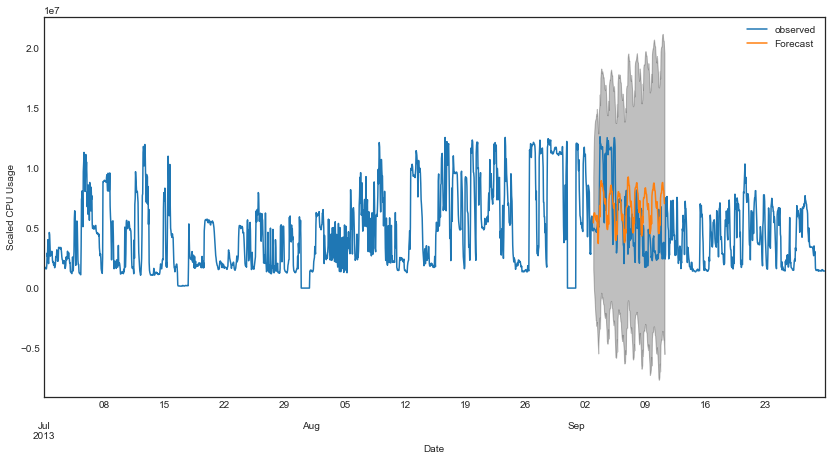

In [167]:
pred_uc = res.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date');
ax.set_ylabel('Scaled CPU Usage');
plt.legend(loc='upper left')
plt.legend()
plt.show()

In [340]:
from sklearn.metrics import mean_squared_error as mae

a = []
for _ in range(2184):
    a.append(1)
b = []
for _ in range(46):
    a.append(1)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_error(y_true,y_pred):
    return np.mean(np.abs(y_true - y_pred))**2  


def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(np.mean(np.abs(y_true - y_pred))**2)



y_forecasted = pred.predicted_mean
y_truth = df['2013':]
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print("Mean absolute percentage Error: {0:.2f}%".format(mape))

mse =  mean_squared_error(y_truth,y_forecasted)
rmse =  mean_squared_error(y_truth,y_forecasted, squared=False)


print("Mean squared Error: "+ str(mse))
print("Root mean squared error is: "+ str(rmse))


Mean absolute percentage Error: 39.72%


TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [461]:
X_train=X_train.values.reshape(1512,1,29)
X_test=X_test.reshape(648,1,29)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [468]:
testPredict=testPredict.reshape(648,)

(648, 1)


In [484]:
print(trainPredict.shape)

(1512, 1)


### LSTM model

Epoch 1/100
19/19 - 3s - loss: 26349848756224.0000 - mape: 10582211.0000 - val_loss: 64765036593152.0000 - val_mape: 44515124.0000
Epoch 2/100
19/19 - 0s - loss: 26349846659072.0000 - mape: 11511145.0000 - val_loss: 64765036593152.0000 - val_mape: 49315724.0000
Epoch 3/100
19/19 - 0s - loss: 26349842464768.0000 - mape: 12609434.0000 - val_loss: 64765036593152.0000 - val_mape: 54449948.0000
Epoch 4/100
19/19 - 0s - loss: 26349844561920.0000 - mape: 13656617.0000 - val_loss: 64765036593152.0000 - val_mape: 58792732.0000
Epoch 5/100
19/19 - 0s - loss: 26349842464768.0000 - mape: 14613637.0000 - val_loss: 64765036593152.0000 - val_mape: 61868072.0000
Epoch 6/100
19/19 - 0s - loss: 26349842464768.0000 - mape: 15206380.0000 - val_loss: 64765036593152.0000 - val_mape: 63943124.0000
Epoch 7/100
19/19 - 0s - loss: 26349842464768.0000 - mape: 15636150.0000 - val_loss: 64765036593152.0000 - val_mape: 65266548.0000
Epoch 8/100
19/19 - 0s - loss: 26349842464768.0000 - mape: 15945091.0000 - val_loss

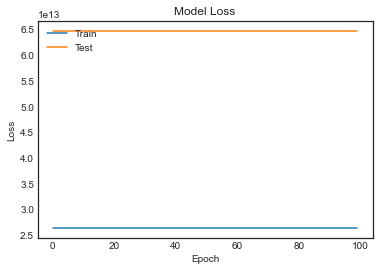

-1.9437728109739965


In [498]:
import os
import matplotlib.pyplot as plt
import pandas as pd

split = 0.8
sequence_length = 60


from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ReduceLROnPlateau #Learning rate scheduler for when we reach plateaus
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

# Reset model if we want to re-train with different splits
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)  


# Epochs and validation split
EPOCHS = 201
validation = 0.3

# Instantiate the model
model = Sequential()

# Add the first layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (1, 29), return_sequences = True,
        units = 32))

# Add the second layer.... the input shape is (Sample, seq_len-1, 1)
model.add(LSTM(
        input_shape = (1, 29), 
        units = 32))

# Add the output layer, simply one unit
model.add(Dense(
        units = 1,
        activation = 'sigmoid'))

adamOpt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adamOpt, metrics=['mape'])
# History object for plotting our model loss by epoch
history = model.fit(X_train, y_train, validation_split=0.2,epochs=100, batch_size=64, verbose=2)
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Creating our future object
future = model.predict(X_train)
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
future=future.reshape(1512,)
mape =r2_score(y_train,future)
print(str(mape))
# Checking its accuracy on our training set


In [499]:
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
testPredict=testPredict.reshape(648,)
trainPredict=trainPredict.reshape(1512,)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_error(y_test, testPredict)
classifi = r2_score(y_test,testPredict,multioutput='variance_weighted')
mse =  mean_squared_error(y_test,testPredict)
rmse = mean_squared_error(y_test,testPredict, squared=False)
mape = mean_absolute_percentage_error(y_test,testPredict)
var = explained_variance_score(y_test,testPredict)
#msle = mean_squared_log_error(y_train,trainPredict)

print("Mean squared Error: "+ str(mse))
print("Root mean squared error is: "+ str(rmse))
print("Mean absolute percentage Error: {0:.2f}%".format(mape))
#print("Mean squared log error: {0:.2f}".format(msle))
print("Explained variance score: {0:.2f}".format(var))     
print("r2 score is {0:.2f}".format(classifi))
print("Mean Absolute Error: {0:.2f}".format(error))

Mean squared Error: 28755271852286.883
Root mean squared error is: 5362394.227608306
Mean absolute percentage Error: 100.00%
Explained variance score: 0.00
r2 score is -3.21
Mean Absolute Error: 4682665.41


In [576]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from math import sqrt
import sys
from scipy import spatial

In [577]:
#pip install keras


In [578]:
#pip install tensorflow

In [706]:

import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 
import keras
import matplotlib.pyplot as plt


In [707]:
print(X.shape)

(1, 2184)


In [708]:
print(X.shape)
X = hourlydat['CPU usage [MHZ]']
X=X.values.reshape(1, -1)

X = X.astype('float32')

scaler = MinMaxScaler(feature_range=(1000000, 100000000))
X = scaler.fit_transform(X)
print(X.shape)

(1, 2184)
(1, 2184)


In [709]:
 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

#look_back = 1
#X_train, y_train = create_dataset(train, look_back)
#X_test, y_test = create_dataset(test, look_back)
#X_test=X_test.to_numpy()
#y_train=y_train.to_numpy()
#y_test=y_test.to_numpy()
#X_train=X_train.to_numpy()
X_train = X_train.reshape(1512, 1,29)
X_test = X_test.reshape(648, 1, 29)
#y_train = y_train.reshape(1512, 1)
#y_test = y_test.reshape(648, 1)
#X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print (X_test.shape)


(648, 1, 29)


In [756]:

model = keras.models.Sequential()
#model.add(keras.layers.LSTM(128, batch_input_shape=(None,1512,25),return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(1, 29), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=True))

model.add(keras.layers.Dense(1))
model.add(keras.layers.Dense(1))

In [757]:
adamOpt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adamOpt, metrics=['mape'])


In [758]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 1, 32)             7936      
_________________________________________________________________
lstm_85 (LSTM)               (None, 1, 32)             8320      
_________________________________________________________________
dense_45 (Dense)             (None, 1, 1)              33        
_________________________________________________________________
dense_46 (Dense)             (None, 1, 1)              2         
Total params: 16,291
Trainable params: 16,291
Non-trainable params: 0
_________________________________________________________________


In [787]:
#history = [x for x in train]
history = model.fit(X_train, y_train, validation_split=0.2,epochs=500, batch_size=64, verbose=2)

Epoch 1/500
19/19 - 0s - loss: 0.0379 - mape: 2389304.0000 - val_loss: 0.1479 - val_mape: 18801850.0000
Epoch 2/500
19/19 - 0s - loss: 0.0380 - mape: 2319039.7500 - val_loss: 0.1466 - val_mape: 18974212.0000
Epoch 3/500
19/19 - 0s - loss: 0.0379 - mape: 2330168.7500 - val_loss: 0.1560 - val_mape: 18455764.0000
Epoch 4/500
19/19 - 0s - loss: 0.0380 - mape: 2341255.0000 - val_loss: 0.1559 - val_mape: 18477248.0000
Epoch 5/500
19/19 - 0s - loss: 0.0379 - mape: 2334255.2500 - val_loss: 0.1535 - val_mape: 18657942.0000
Epoch 6/500
19/19 - 0s - loss: 0.0378 - mape: 2294839.5000 - val_loss: 0.1586 - val_mape: 18397308.0000
Epoch 7/500
19/19 - 0s - loss: 0.0379 - mape: 2354895.2500 - val_loss: 0.1475 - val_mape: 18980422.0000
Epoch 8/500
19/19 - 0s - loss: 0.0377 - mape: 2257804.0000 - val_loss: 0.1517 - val_mape: 18795570.0000
Epoch 9/500
19/19 - 0s - loss: 0.0378 - mape: 2291456.2500 - val_loss: 0.1579 - val_mape: 18599570.0000
Epoch 10/500
19/19 - 0s - loss: 0.0378 - mape: 2365412.5000 - va

In [788]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
trainPredict = trainPredict.reshape(1512, 1)
testPredict = testPredict.reshape(648, )
print(testPredict.shape)
print(trainPredict.shape)


(1512, 1, 29)
(648, 1, 29)
(1512, 1)
(648, 1)
(648,)
(1512, 1)


In [789]:
model.metrics_names

['loss', 'mape']

In [790]:
model.evaluate(X_test,y_test)

21/21 [==============================] - 0s 648us/step - loss: 0.0656 - mape: 394500.7500


[0.06556130200624466, 394500.75]

In [791]:
y_train

array([[0.22445679],
       [0.18035429],
       [0.1703488 ],
       ...,
       [0.45701887],
       [0.38217706],
       [0.380088  ]])

In [792]:
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_error(y_test, testPredict)
classifi = r2_score(y_test,testPredict,multioutput='variance_weighted')
mse =  mean_squared_error(y_test,testPredict)
rmse = mean_squared_error(y_test,testPredict, squared=False)
mape = mean_absolute_percentage_error(y_test,testPredict)
var = explained_variance_score(y_test,testPredict)
#msle = mean_squared_log_error(y_train,trainPredict)

print("Mean squared Error: "+ str(mse))
print("Root mean squared error is: "+ str(rmse))
print("Mean absolute percentage Error: {0:.2f}%".format(mape))
#print("Mean squared log error: {0:.2f}".format(msle))
print("Explained variance score: {0:.2f}".format(var))     
print("r2 score is {0:.2f}".format(classifi))
print(str(error))



Mean squared Error: 0.06556130024906921
Root mean squared error is: 0.25604940978074764
Mean absolute percentage Error: inf%
Explained variance score: -0.20
r2 score is -0.22
0.20323566767440499


In [793]:
scaler = MinMaxScaler()
#X = scaler.fit_transform(X)
y_train =y_train.reshape(1512, 1)
y_test =y_test.reshape(648, 1)
testPredict = testPredict.reshape(648, 1)
trainPredict = trainPredict.reshape(1512, 1)
y_train = scaler.fit_transform(y_train)
y_train = scaler.inverse_transform(y_train)
trainPredict = scaler.fit_transform(trainPredict)
y_test = scaler.inverse_transform(y_test)
testPredict = scaler.fit_transform(testPredict)
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.fit_transform(y_train)
testPredict = scaler.fit_transform(testPredict)
y_test= scaler.fit_transform(y_test)

In [794]:
#y_train=y_train.to_numpy()
#y_train.reshape(4536, 1)
#X = X.reshape(2184, 3)
#np.resize(trainPredict,(1512,1))
print(y_test.shape)

(648, 1)


In [795]:
trainScore = math.sqrt(mean_squared_error(y_train[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.39 RMSE
Test Score: 0.28 RMSE


In [796]:
testPredict = testPredict.reshape(648, )

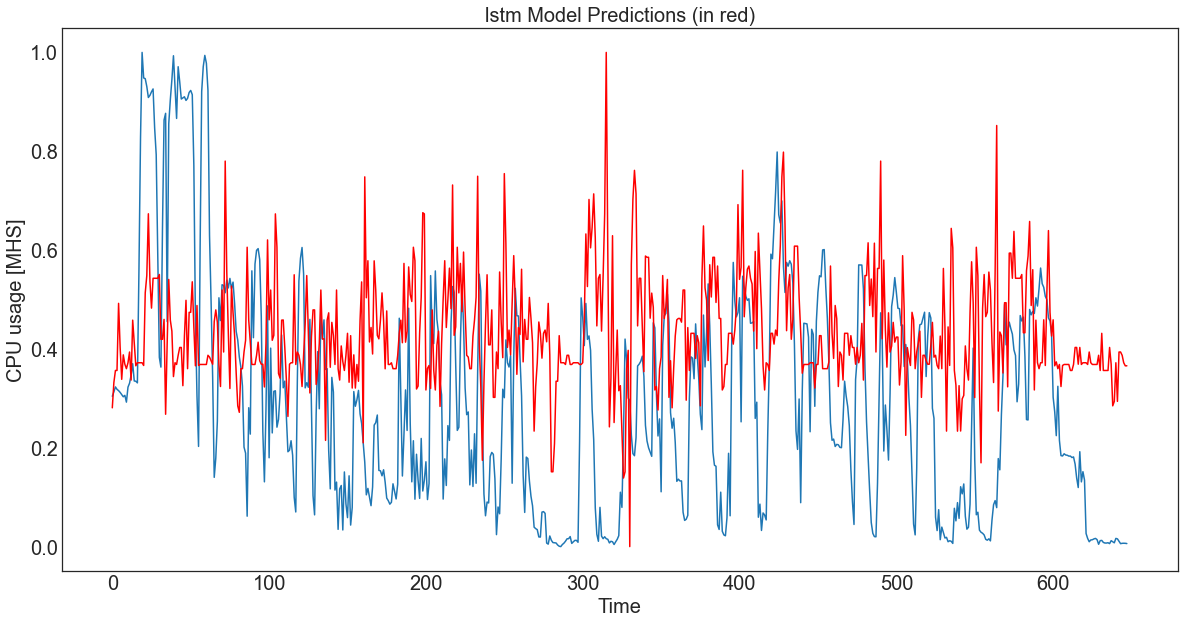

In [797]:
testnew = y_test

prednew = testPredict

plt.figure(figsize=(20,10))
plt.plot(testnew)
plt.plot(prednew, color='red')
plt.tick_params(labelsize=20)
plt.title("lstm Model Predictions (in red)", fontsize = 20)
plt.ylabel("CPU usage [MHS]", fontsize = 20)
plt.xlabel("Time", fontsize = 20)
plt.show();

In [ ]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import seaborn as sns
import sklearn
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor

In [ ]:
random_state = 42
n_jobs = 1  # Parallelisation factor for bagging, random forests
n_estimators = 1000
step_factor = 10
axis_step = int(n_estimators/step_factor)

In [ ]:
estimators = np.zeros(axis_step)
bagging_mse = np.zeros(axis_step)
rf_mse = np.zeros(axis_step)
boosting_mse = np.zeros(axis_step)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
X_train=X_train.reshape(-1,25)
X_test=X_test.reshape(-1,25)

In [ ]:
for i in range(0, axis_step):
    print("Bagging Estimator: %d of %d..." % (
        step_factor*(i+1), n_estimators)
    )
    bagging = BaggingRegressor(
        DecisionTreeRegressor(), 
        n_estimators=step_factor*(i+1),
        n_jobs=n_jobs,
        random_state=random_state
    )
    bagging.fit(X_train, y_train)
    mse = mean_squared_error(y_test, bagging.predict(X_test))
    estimators[i] = step_factor*(i+1)
    bagging_mse[i] = mse

In [ ]:
for i in range(0, axis_step):
    print("Random Forest Estimator: %d of %d..." % (
        step_factor*(i+1), n_estimators)
    )
    rf = RandomForestRegressor(
        n_estimators=step_factor*(i+1),
        n_jobs=n_jobs,
        random_state=random_state
    )
    rf.fit(X_train, y_train)
    mse = mean_squared_error(y_test, rf.predict(X_test))
    estimators[i] = step_factor*(i+1)
    rf_mse[i] = mse

In [ ]:
for i in range(0, axis_step):
    print("Boosting Estimator: %d of %d..." % (
        step_factor*(i+1), n_estimators)
    )
    boosting = AdaBoostRegressor(
        DecisionTreeRegressor(),
        n_estimators=step_factor*(i+1),
        random_state=random_state,
        learning_rate=0.01
    )
    boosting.fit(X_train, y_train)
    mse = mean_squared_error(y_test, boosting.predict(X_test))
    estimators[i] = step_factor*(i+1)
    boosting_mse[i] = mse

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('Bagging, Random Forest and Boosting comparison')
plt.plot(estimators, bagging_mse, 'b-', color="black", label='Bagging')
plt.plot(estimators, rf_mse, 'b-', color="blue", label='Random Forest')
plt.plot(estimators, boosting_mse, 'b-', color="red", label='AdaBoost')
plt.legend(loc='upper right')
plt.xlabel('Estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

In [ ]:
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

In [ ]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

In [ ]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

In [ ]:
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

[ 5619798.5  6036742.5  4576444.5  5618345.5  5034635.   4549230.
  3802641.5  4102358.5  4594147.   4007498.   4639667.5  5494909.
  4841779.   4938670.5  4901174.5  5123717.5  5022245.   6938184.
  8219387.5  6834154.5  8688885.  10144442.   9513948.  10538695.
 10355058.  11094631.  10445898.   9356043.  10321524.  10073941.
  8398883.   9100262.   7340654.   6543277.5  5698054.5  5566657.
  8767577.   9625457.   7262009.   8168676.   9701599.  11496496.
 11165244.   8968519.   9803211.  10223110.  11283257.   9927253.
  9480158.   9710175.   9298970.  10593435.   8483287.   7351528.
  8788669.   6312331.5  6221293.5  5811642.   5490739.5  6666606.5
  8127564.5 10347638.   9722074.  10631958.  10499960.   8568529.
  9259629.   5924954.5  4691423.   5265857.   6051587.5  7835064.5
  6136840.   6656836.   7388964.   7124445.5  7506363.5  6712792.5
  5270739.   6860667.5  7063919.   7193878.   7989504.5  6549524.
  5753989.   4593809.5  4040385.8  7148428.   5887631.5  6589581.
  69484

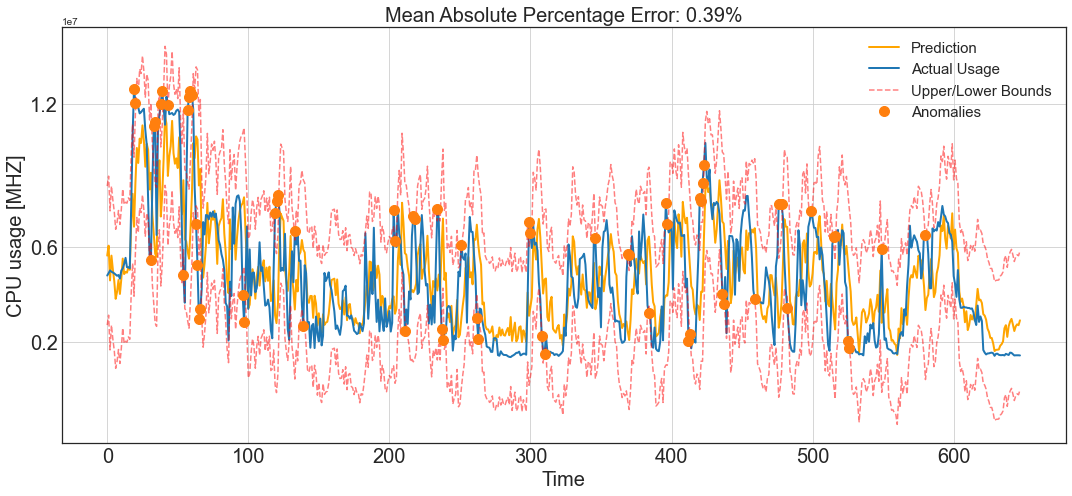

In [330]:
import xgboost
from xgboost import XGBRegressor 
import lightgbm as lgb
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.3, gamma=0,
         importance_type='gain', learning_rate=0.1, max_delta_step=0,
         max_depth=4, min_child_weight=1, missing=1, n_estimators=80,
         n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
         silent=None, subsample=0.5, verbosity=1)   
xgb.fit(X_train, y_train)
prediction4 = xgb.predict(X_test)
error_xgb = mean_absolute_percentage_error(prediction4, y_test)
plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [310]:
print(error_xgb)

32.55429348438506


In [196]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lightgbm_params = {'boosting_type': 'gbdt', 
         'colsample_bytree': 0.65, 
         'learning_rate': 0.001, 
       'n_estimators': 20, 
         'num_leaves': 3, 
         'reg_alpha': 0.5, 
         'reg_lambda': 0.5, 
         'subsample': 0.7}
gbm = lgb.train(lightgbm_params,lgb_train,num_boost_round=10,valid_sets=lgb_eval)
prediction5 = gbm.predict(X_test_scaled)
error_lightgbm = mean_absolute_percentage_error(prediction5, y_test)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6736
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 29
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4741517.006076


In [218]:
print(error_lightgbm)

44.827111410242196


In [219]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
prediction1 = lr.predict(X_test_scaled)
error_linear = mean_absolute_percentage_error(prediction1, y_test)

In [220]:
print(error_linear)

30.60812748949807


In [221]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)
prediction2 = ridge.predict(X_test_scaled)
error_ridge = mean_absolute_percentage_error(prediction2, y_test)

In [222]:
print(error_ridge)

30.612169223736647


In [223]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)
prediction3 = lasso.predict(X_test_scaled)
error_lasso = mean_absolute_percentage_error(prediction3, y_test)

In [224]:
print(error_lasso)

30.992106869483138


In [322]:
stack_error = mean_absolute_percentage_error(prediction1*0.1+prediction2*0.35+prediction3*0.6, y_test)

In [336]:
print(r2)

1824782.0685435003


In [335]:
r2 = mean_squared_error(prediction1*0.1+prediction2*0.35+prediction3*0.6, y_test,squared=False)